# DSI Team Starting Point

### Background

DSI Phase I:
- Cleaned and Analyzed Historical CFPB Agreement Data looking to understand offered APRs
    - Team found initial analysis lacking in meaning due to the nature of the APR values reported in the agreements
        - The Reported APRs were listed as a "middle point" across customer segments per plan per agreement.
        - This ultiamtely meant that the APR value was already a range or a value from a range rather than the discreet values themselves.
    - Later found out from data stewards that the historical data is non-verifiable, meaning the reported APRs were hard to relate to the actual offerings at that time.
    - Data Teams Presentations:
        - <a href="https://github.com/chrisJoyceDS/top_sprint_data/blob/main/code/CFPB_Data.ipynb"> Jupyter Notebook Repo </a>
        - <a href="https://docs.google.com/presentation/d/16vBsI7b5Fw_0tF1UQK4qW2dn32v66PwcC3VZ959mx4c/edit#slide=id.p"> Presentation to the Team </a>
        - <a href="https://docs.google.com/presentation/d/18uy5qkw0zQTg-SA-ceXDKOI2dCI4RLN-IjSQXfIwCIM/edit#slide=id.p"> Presentation to the CFPB </a>

DSI Phase II:
- After having it confirmed that the historical data was innacurate and far from reality, the team learned of and used the updated dataset provided by the CFPB
- This data was from July 2022 to December 2022 and had a variety of updated information with respect to the historical data
- Unfortunately there is no data dictionary for this dataset, and we will have to interpet their values based on the column descriptions
- for the sake of the team, we left most of the column names intact, and update a few where we thought it was best/relevant
- Please follow us along or Select "Jump to Clustering" below:

[Jump to Clustering](#Clustering)

In [1169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
import seaborn as sns
import re
import missingno as msno

# imputing
from sklearn.impute import KNNImputer
# preprocessing
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import make_column_transformer
#clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

- The dataset data doesn't fall on the usual A0 cell, we needed to adjust the pandas reader

In [1170]:
columns_to_read = 'B:FO'

In [1171]:
df = pd.read_excel("../data/cfpb_updated_tccp.xlsx",skiprows=9,usecols=columns_to_read)

In [1172]:
df.head()

,Institution Name,Product Name,Report Date,Availability of Credit Card Plan,State,State (Multiple),Pertains to Specific Counties?,Requirements for Opening,Requirements for Opening Types,Geographic Restrictions,...,Services,Other Services,Rewards,Other Rewards,Card Features,Other Card Features,Contact Information Types,Website for Consumer,Telephone Number for Consumers,Created Date
0,FNBT BANK,MasterCard,Data as of December 31,National,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,Cashback rewards,NaN,Chip card,NaN,Phone; Website,https:www.fnbt.com,1-800-899-4321,3/21/2023
1,WINTHROP AREA FEDERAL CREDIT UNION,Visa Credit Platinum,Data as of December 31,National,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,Cashback rewards; Travel-related rewards,NaN,Contactless Payments; Chip card; Fee-free fore...,NaN,Phone; Website,https://www.winthropcreditunion.org,800-511-1120,3/21/2023
2,WOORI AMERICA BANK,Classic,Data as of December 31,National,NaN,NaN,NaN,Yes,NaN,NaN,...,Automobile rental insurance; Credit card regis...,NaN,Travel-related rewards,NaN,Chip card; Fee-free foreign transactions; Mobi...,NaN,Website,https://www.wooriamericabank.com,NaN,3/21/2023
3,CENTRAL BANK & TRUST COMPANY,Classic Visa,Data as of December 31,Regional,NaN,IN; KY; OH,No,Yes,NaN,NaN,...,Automobile rental insurance; Other,Roadside assistance,NaN,NaN,Contactless Payments; Chip card; Mobile wallet...,NaN,Phone; Website,https://www.centralbank.com,(800)637-6884,3/22/2023
4,CLEARWATER FEDERAL CREDIT UNION,Visa,Data as of December 31,National,NaN,NaN,NaN,No,Other. Please Describe:,NaN,...,Debt cancellation coverage; Other,Visa's credit monitoring (Norton Lifelock cred...,NaN,NaN,Contactless Payments; Chip card; Mobile wallet...,NaN,Phone; Website,https://www.clearwatercreditunion.org,800-254-1803,3/22/2023


In [1173]:
df.shape

(648, 170)

- Key differences between this data set and the historical data set
    - This is not timeseries, it is each institution's plan data as of December 31 of the participants in the survey
    - Phase I dataset was (rows:9556,columns:12)
    - more dense of a dataset
- let's check out the null landscape below

<Axes: >

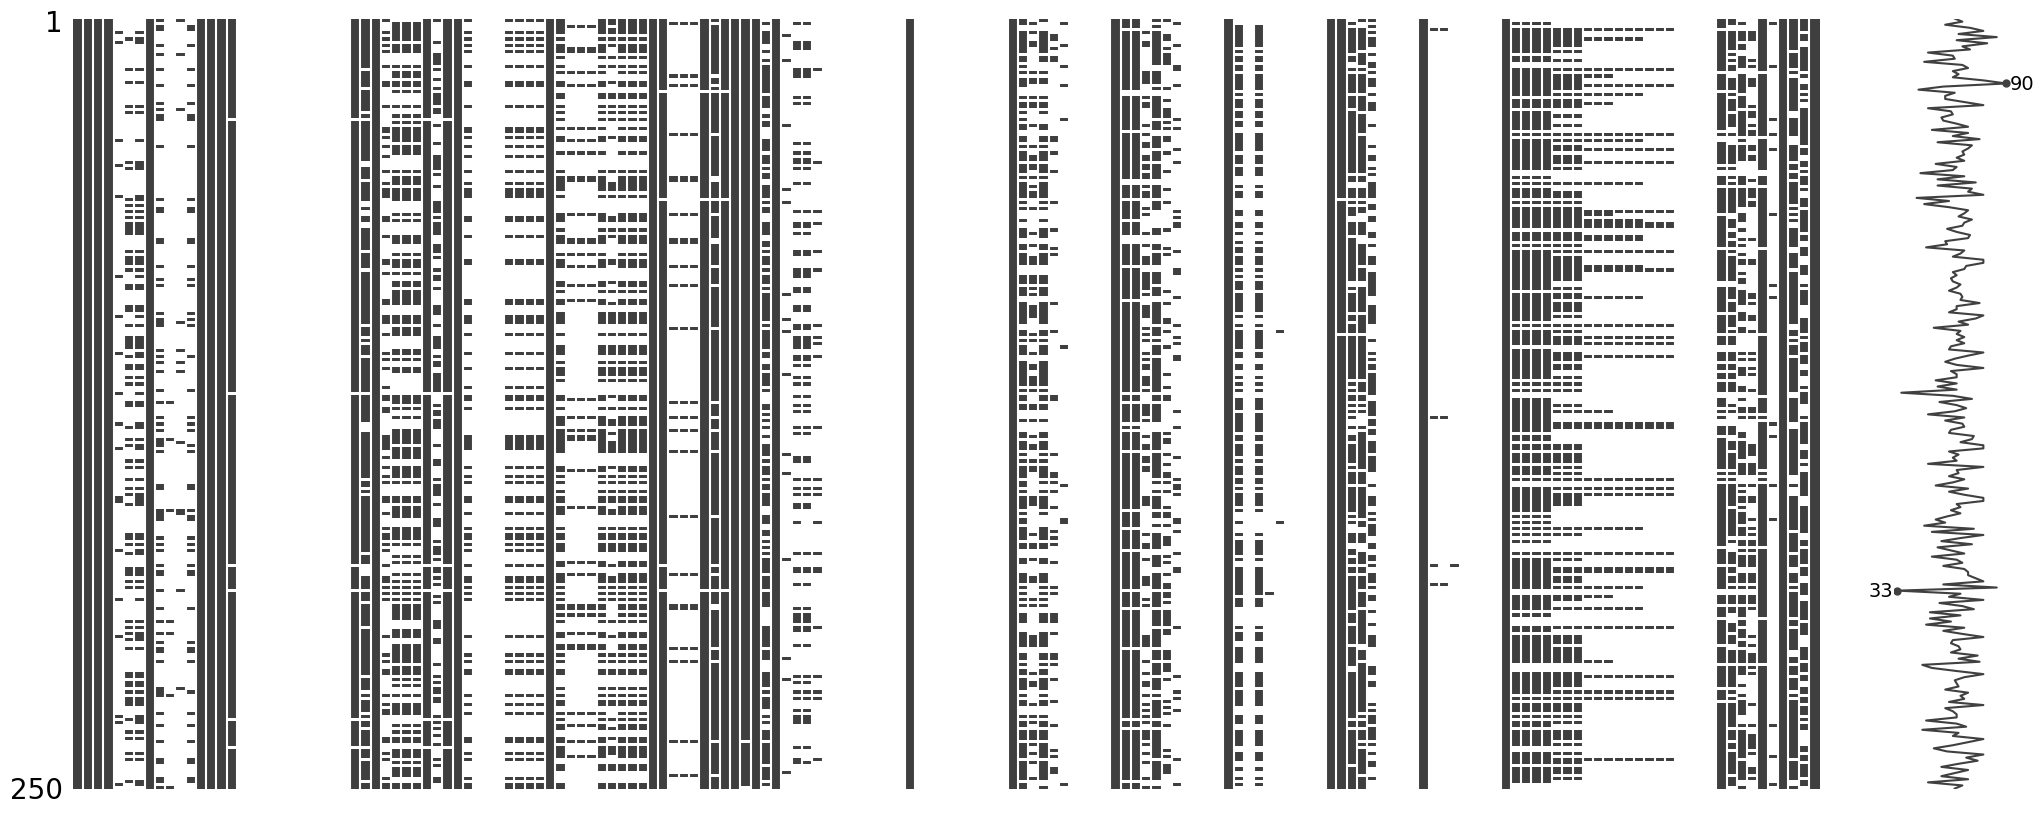

In [1174]:
msno.matrix(df.sample(250))

- What you are seeing is a graphical representation of the data within the new data set:
    - Black means data
    - White means no data
- With more fields collected, comes the even possibility of not collecting it.
- Below is the start of our initial clean process. Because of the look of the dataset above, and the sheer amount of initial features we have (170) we are going to make some swift cuts

In [1175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Columns: 170 entries, Institution Name to Created Date
dtypes: float64(97), object(73)
memory usage: 860.8+ KB


In [1176]:
# Calculate the percentage of null values in each column
null_percentage = (df.isnull().sum() / len(df)) * 100

In [1177]:
type(null_percentage)

pandas.core.series.Series

In [1178]:
null_percentage.shape

(170,)

In [1179]:
# set threshold
threshold = 90

In [1180]:
# Create a list of column names to drop where the null percentage is greater than or equal to the threshold
columns_to_drop = null_percentage[null_percentage >= threshold].index.tolist()

In [1181]:
len(columns_to_drop)

68

In [1182]:
# drop the columns
df.drop(columns=columns_to_drop,inplace=True)

In [1183]:
df.shape

(648, 102)

- Above we:
    - Calculated the null percentage for each column of the 170
    - set a threshold of 90 percent null as the cut off
    - removed all columns that met that threshould and above
    - resulting in dropping 68 columns
- You can see the impact below, and it's much better, but we still have 102 features, which means we will be greedier in our selection

<Axes: >

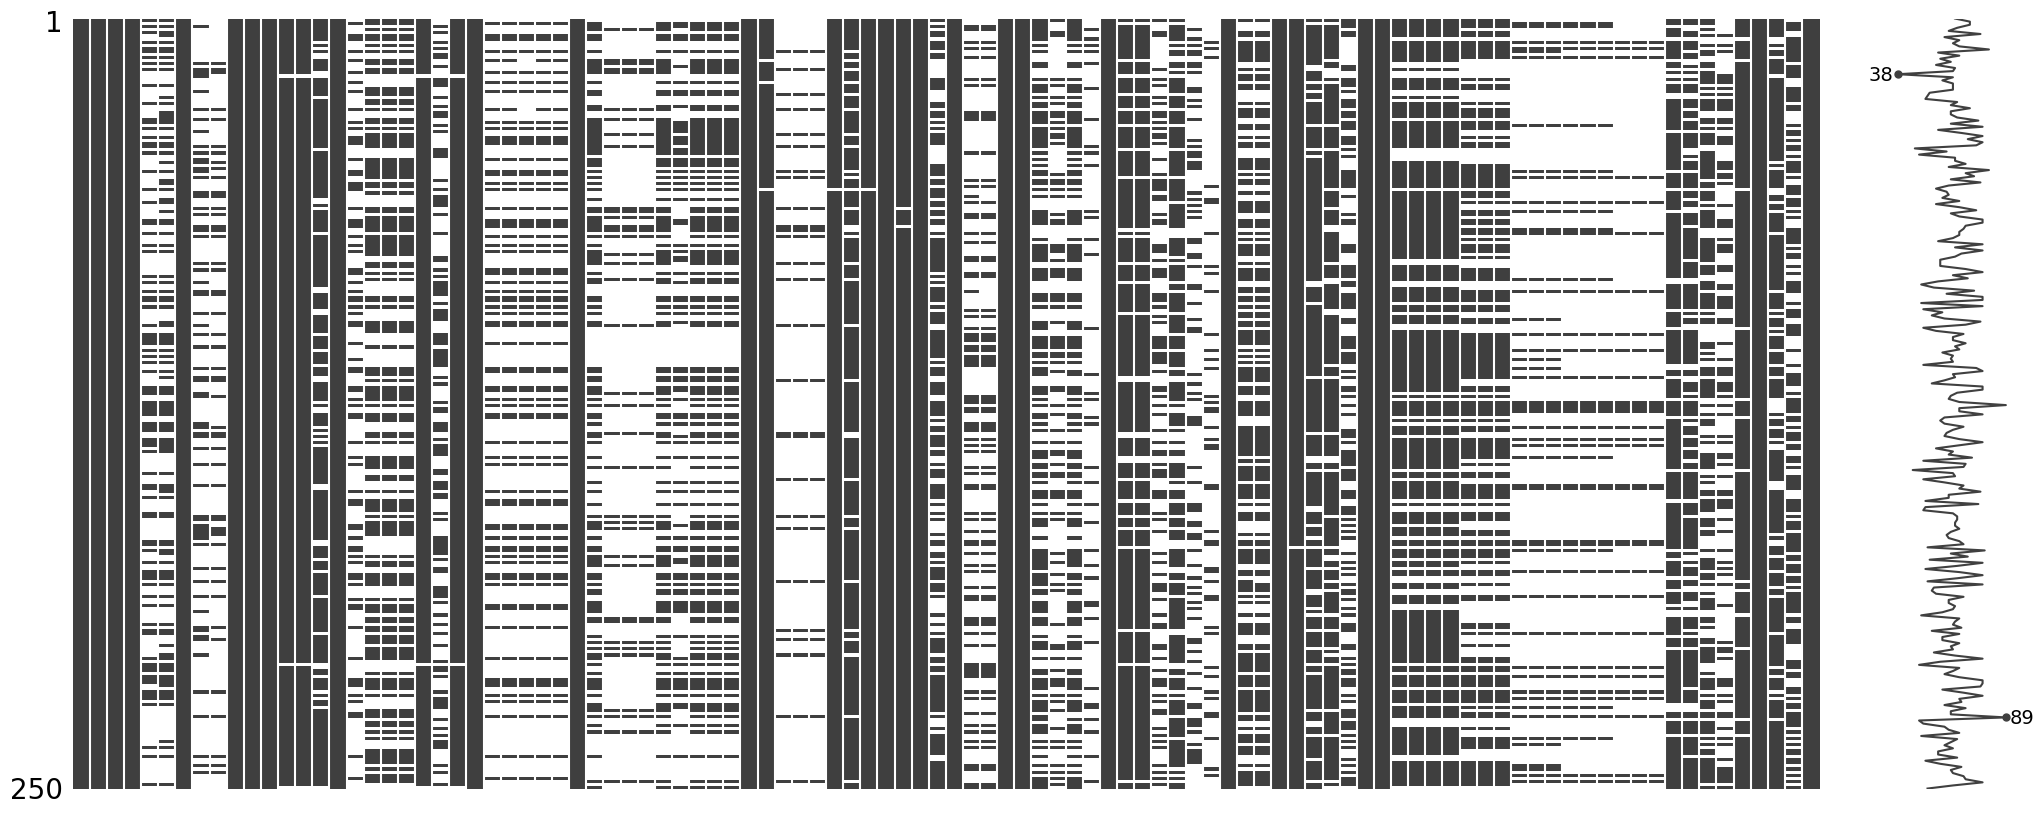

In [1184]:
msno.matrix(df.sample(250))

In [1185]:
df.head()

,Institution Name,Product Name,Report Date,Availability of Credit Card Plan,State (Multiple),Pertains to Specific Counties?,Requirements for Opening,Requirements for Opening Types,Other,Secured Card,...,Other Fee Explanation.4,Services,Other Services,Rewards,Other Rewards,Card Features,Contact Information Types,Website for Consumer,Telephone Number for Consumers,Created Date
0,FNBT BANK,MasterCard,Data as of December 31,National,NaN,NaN,No,NaN,NaN,No,...,NaN,NaN,NaN,Cashback rewards,NaN,Chip card,Phone; Website,https:www.fnbt.com,1-800-899-4321,3/21/2023
1,WINTHROP AREA FEDERAL CREDIT UNION,Visa Credit Platinum,Data as of December 31,National,NaN,NaN,No,NaN,NaN,No,...,NaN,NaN,NaN,Cashback rewards; Travel-related rewards,NaN,Contactless Payments; Chip card; Fee-free fore...,Phone; Website,https://www.winthropcreditunion.org,800-511-1120,3/21/2023
2,WOORI AMERICA BANK,Classic,Data as of December 31,National,NaN,NaN,Yes,NaN,NaN,No,...,NaN,Automobile rental insurance; Credit card regis...,NaN,Travel-related rewards,NaN,Chip card; Fee-free foreign transactions; Mobi...,Website,https://www.wooriamericabank.com,NaN,3/21/2023
3,CENTRAL BANK & TRUST COMPANY,Classic Visa,Data as of December 31,Regional,IN; KY; OH,No,Yes,NaN,NaN,No,...,NaN,Automobile rental insurance; Other,Roadside assistance,NaN,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,https://www.centralbank.com,(800)637-6884,3/22/2023
4,CLEARWATER FEDERAL CREDIT UNION,Visa,Data as of December 31,National,NaN,NaN,No,Other. Please Describe:,Person must qualify for membership based on th...,No,...,NaN,Debt cancellation coverage; Other,Visa's credit monitoring (Norton Lifelock cred...,NaN,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,https://www.clearwatercreditunion.org,800-254-1803,3/22/2023


In [1186]:
# get remaining column data types
col_types = df.dtypes

In [1187]:
# separate out numerical and object columns
num_cols = col_types[col_types != 'object'].index.tolist()
obj_cols = col_types[col_types == 'object'].index.tolist()

In [1188]:
df[num_cols].shape

(648, 40)

In [1189]:
df[obj_cols].shape

(648, 62)

In [1190]:
df[num_cols].isnull().sum().sum(), df[obj_cols].isnull().sum().sum()

(13313, 11087)

In [1191]:
# re-Calculate the percentage of null values in each column
null_percentage = (df.isnull().sum() / len(df)) * 100

In [1192]:
null_percentage.sort_values(ascending=False)[null_percentage >= 59]

Good Credit.3                           89.197531
Great Credit.3                          89.197531
Poor or Fair Credit.3                   89.197531
Other Fee Explanation.4                 88.425926
Other Fee Name.4                        88.425926
Other Fee Amount.4                      88.425926
Other Fee Name.3                        83.796296
Poor or Fair Credit.2                   83.796296
Other Fee Amount.3                      83.796296
Other Fee Explanation.3                 83.796296
Good Credit.2                           83.796296
Great Credit.2                          83.796296
Cash Advance Fee Calculation            81.481481
Other Fee Amount.2                      81.481481
Other Fee Explanation.2                 81.481481
Other Fee Name.2                        81.481481
Other                                   80.555556
Minimum Balance Transfer Fee Amount     80.401235
Requirements for Opening Types          75.000000
Minimum Cash Advance Fee Amount         68.827160


In [1193]:
# additional columns to drop
cols_to_drop = null_percentage[null_percentage >= 60].index.tolist()

In [1194]:
len(cols_to_drop)

34

In [1195]:
# drop additional columns
# drop the columns
df.drop(columns=cols_to_drop,inplace=True)

In [1196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 68 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Institution Name                          648 non-null    object 
 1   Product Name                              648 non-null    object 
 2   Report Date                               648 non-null    object 
 3   Availability of Credit Card Plan          648 non-null    object 
 4   Requirements for Opening                  648 non-null    object 
 5   Secured Card                              648 non-null    object 
 6   Targeted Credit Tiers                     648 non-null    object 
 7   Purchase APR Offered?                     648 non-null    object 
 8   Purchase APR Vary by Balance              634 non-null    object 
 9   Purchase APR Index                        634 non-null    object 
 10  Variable Rate Index                   

- Same exercise, new threshold, this time anything that was greater or equal to 59% null
- Now we have 68 Columns (5.5 times the features we had with historical btw) with a much better look of data below

<Axes: >

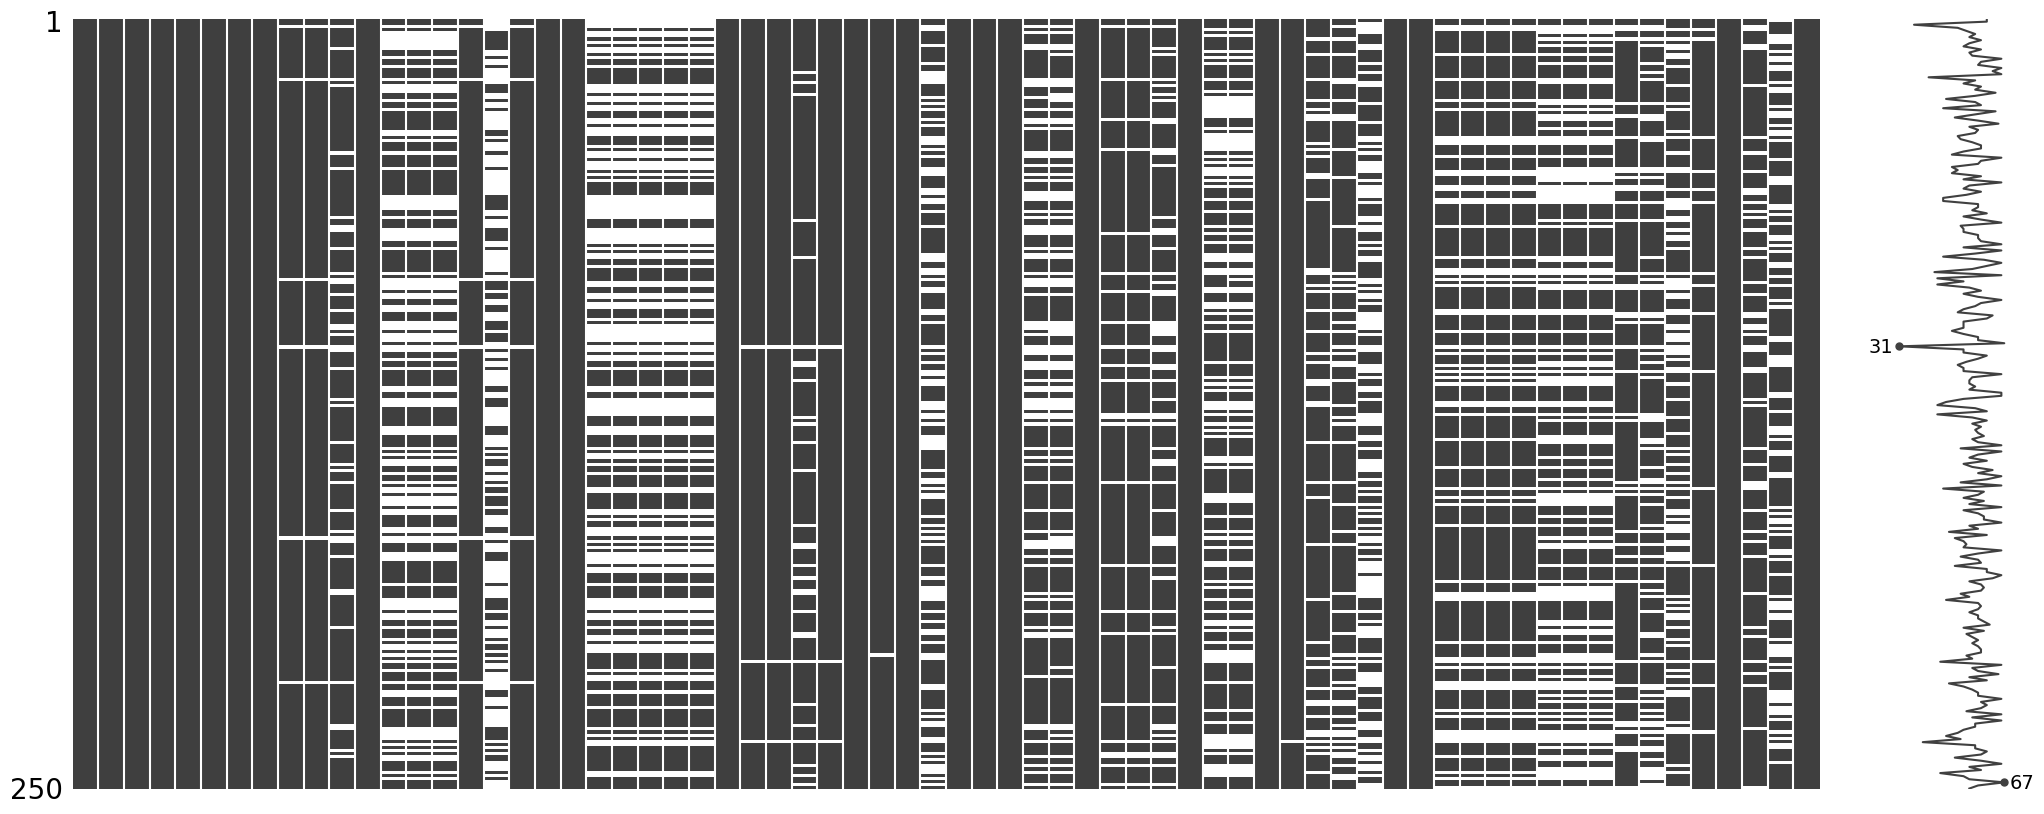

In [1197]:
msno.matrix(df.sample(250))

In [1198]:
df.columns.shape

(68,)

- Something you will have noticed, if you read our initial analysis, is that there are less visualizations for this data set
- There will be more going forward, but for now we have prioritized creating aggregate cards for the Software Engineering Team to be able to start building
- From this point we will be doing a mix of cleaning, feature engineering, preprocessing, and clustering

---
## MVP Goal

- Create Aggregate cards based on the targeted credit tiers 
- Capture APR, Grace Periods, Late Fees, Rewards, and Annual Fees

In [1199]:
df["Targeted Credit Tiers"] = df["Targeted Credit Tiers"].apply(lambda x: x.lower())

In [1200]:
df["Targeted Credit Tiers"].value_counts()

Targeted Credit Tiers
poor or fair credit (credit score 619 or less); good credit (credit scores from 620 to 719); great credit (credit score of 720 or greater)    275
good credit (credit scores from 620 to 719); great credit (credit score of 720 or greater)                                                    164
great credit (credit score of 720 or greater)                                                                                                  89
poor or fair credit (credit score 619 or less)                                                                                                 80
good credit (credit scores from 620 to 719)                                                                                                    34
poor or fair credit (credit score 619 or less); good credit (credit scores from 620 to 719)                                                     6
Name: count, dtype: int64

- split the strings on the ';'
- for the non technical this just makes it easier for us to interact with
- Goes from:
    - good credit (credit scores from 620 to 719); great credit (credit score of 720 or greater) 
    - to
    - ['good credit (credit scores from 620 to 719)',
 'great credit (credit score of 720 or greater)']

In [1201]:
df["Targeted Credit Tiers"] = df["Targeted Credit Tiers"].str.split("; ")

- Create three columns that align with the credit score group.
- if the word is found in a given list of options for a specific group, report True, else False 

In [1202]:
# Create Separate Columns for each bucket
df['Poor_Fair_Group'] = df['Targeted Credit Tiers'].apply(lambda x: any(re.search(r'poor', s) for s in x))
df['Good_Credit_Group'] = df['Targeted Credit Tiers'].apply(lambda x: any(re.search(r'good', s) for s in x))
df['Great_Credit_Group'] = df['Targeted Credit Tiers'].apply(lambda x: any(re.search(r'great', s) for s in x))

In [1203]:
df[['Poor_Fair_Group','Good_Credit_Group','Great_Credit_Group']]

,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group
0,False,True,False
1,False,True,True
2,False,True,True
3,True,True,True
4,True,True,True
...,...,...,...
643,False,False,True
644,False,False,True
645,False,False,True
646,True,True,True


In [1204]:
# convert boolean into numerical values
df['Poor_Fair_Group'] = df['Poor_Fair_Group'].astype(int)
df['Good_Credit_Group'] = df['Good_Credit_Group'].astype(int)
df['Great_Credit_Group'] = df['Great_Credit_Group'].astype(int)

In [1205]:
df[['Poor_Fair_Group','Good_Credit_Group','Great_Credit_Group']].head()

,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group
0,0,1,0
1,0,1,1
2,0,1,1
3,1,1,1
4,1,1,1


In [1206]:
df.columns

Index(['Institution Name', 'Product Name', 'Report Date',
       'Availability of Credit Card Plan', 'Requirements for Opening',
       'Secured Card', 'Targeted Credit Tiers', 'Purchase APR Offered?',
       'Purchase APR Vary by Balance', 'Purchase APR Index',
       'Variable Rate Index', 'Index', 'Poor or Fair Credit', 'Good Credit',
       'Great Credit', 'Minimum APR', 'Median APR', 'Maximum APR',
       'Introductory APR Offered?', 'Balance Transfer Offered?',
       'Balance Transfer APR Vary by Credit Tier', 'Minimum APR.2',
       'Maximum APR.2', 'Median Length of Balance Transfer APR',
       'Balance Transfer Grace Period', 'Cash Advance APR Offered?',
       'Cash Advance APR Vary by Credit Tier', 'Minimum APR.3', 'Median APR.3',
       'Maximum APR.3', 'Grace Period Offered?', 'Grace Period',
       'Minimum Finance Charge?', 'Minimum Finance Charge (Dollars)',
       'Balance Computation Method', 'Purchase Transaction Fees',
       'Balance Transfer Fees?', 'Balance Tra

In [1207]:
df.head()

,Institution Name,Product Name,Report Date,Availability of Credit Card Plan,Requirements for Opening,Secured Card,Targeted Credit Tiers,Purchase APR Offered?,Purchase APR Vary by Balance,Purchase APR Index,...,Other Services,Rewards,Card Features,Contact Information Types,Website for Consumer,Telephone Number for Consumers,Created Date,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group
0,FNBT BANK,MasterCard,Data as of December 31,National,No,No,[good credit (credit scores from 620 to 719)],Yes,No,No,...,NaN,Cashback rewards,Chip card,Phone; Website,https:www.fnbt.com,1-800-899-4321,3/21/2023,0,1,0
1,WINTHROP AREA FEDERAL CREDIT UNION,Visa Credit Platinum,Data as of December 31,National,No,No,"[good credit (credit scores from 620 to 719), ...",Yes,No,No,...,NaN,Cashback rewards; Travel-related rewards,Contactless Payments; Chip card; Fee-free fore...,Phone; Website,https://www.winthropcreditunion.org,800-511-1120,3/21/2023,0,1,1
2,WOORI AMERICA BANK,Classic,Data as of December 31,National,Yes,No,"[good credit (credit scores from 620 to 719), ...",Yes,No,Yes,...,NaN,Travel-related rewards,Chip card; Fee-free foreign transactions; Mobi...,Website,https://www.wooriamericabank.com,NaN,3/21/2023,0,1,1
3,CENTRAL BANK & TRUST COMPANY,Classic Visa,Data as of December 31,Regional,Yes,No,[poor or fair credit (credit score 619 or less...,No,NaN,NaN,...,Roadside assistance,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,https://www.centralbank.com,(800)637-6884,3/22/2023,1,1,1
4,CLEARWATER FEDERAL CREDIT UNION,Visa,Data as of December 31,National,No,No,[poor or fair credit (credit score 619 or less...,Yes,No,No,...,Visa's credit monitoring (Norton Lifelock cred...,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,https://www.clearwatercreditunion.org,800-254-1803,3/22/2023,1,1,1


Immediately, some of these columns are aparently redundant. For instance:

In [1208]:
df[['Purchase APR Offered?', 'Purchase APR Vary by Balance']]

,Purchase APR Offered?,Purchase APR Vary by Balance
0,Yes,No
1,Yes,No
2,Yes,No
3,No,NaN
4,Yes,No
...,...,...
643,Yes,No
644,Yes,No
645,Yes,No
646,Yes,No


Whether an APR is offered is already represented in `Purchase APR Vary by Balance` because in cases where an APR is not offered, there will be a NaN. That said, I am going to have to impute these NaNs before I can cluster, so this relationship will be lost, but would be retained by `Purchase APR Offered?` if I decide to keep this feature.

Some other features I assume won't be useful:

In [1209]:
df[['Website for Consumer','Telephone Number for Consumers']]

,Website for Consumer,Telephone Number for Consumers
0,https:www.fnbt.com,1-800-899-4321
1,https://www.winthropcreditunion.org,800-511-1120
2,https://www.wooriamericabank.com,NaN
3,https://www.centralbank.com,(800)637-6884
4,https://www.clearwatercreditunion.org,800-254-1803
...,...,...
643,NaN,1-800-792-0001
644,https://creditcards.chase.com/travel-credit-ca...,1-800-698-0120
645,https://creditcards.chase.com/southwest/priori...,1-800-792-0001
646,https://www.kfcu.org,NaN


Is there a real relationship between credit score and the URL/phone number of the company offering a credit card? Probably not. I'll drop these features.

In [1210]:
df.drop(columns = ['Website for Consumer','Telephone Number for Consumers'], inplace = True)

In [1211]:
df.head()

,Institution Name,Product Name,Report Date,Availability of Credit Card Plan,Requirements for Opening,Secured Card,Targeted Credit Tiers,Purchase APR Offered?,Purchase APR Vary by Balance,Purchase APR Index,...,Other Fee Explanation.1,Services,Other Services,Rewards,Card Features,Contact Information Types,Created Date,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group
0,FNBT BANK,MasterCard,Data as of December 31,National,No,No,[good credit (credit scores from 620 to 719)],Yes,No,No,...,NaN,NaN,NaN,Cashback rewards,Chip card,Phone; Website,3/21/2023,0,1,0
1,WINTHROP AREA FEDERAL CREDIT UNION,Visa Credit Platinum,Data as of December 31,National,No,No,"[good credit (credit scores from 620 to 719), ...",Yes,No,No,...,NaN,NaN,NaN,Cashback rewards; Travel-related rewards,Contactless Payments; Chip card; Fee-free fore...,Phone; Website,3/21/2023,0,1,1
2,WOORI AMERICA BANK,Classic,Data as of December 31,National,Yes,No,"[good credit (credit scores from 620 to 719), ...",Yes,No,Yes,...,NaN,Automobile rental insurance; Credit card regis...,NaN,Travel-related rewards,Chip card; Fee-free foreign transactions; Mobi...,Website,3/21/2023,0,1,1
3,CENTRAL BANK & TRUST COMPANY,Classic Visa,Data as of December 31,Regional,Yes,No,[poor or fair credit (credit score 619 or less...,No,NaN,NaN,...,NaN,Automobile rental insurance; Other,Roadside assistance,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,3/22/2023,1,1,1
4,CLEARWATER FEDERAL CREDIT UNION,Visa,Data as of December 31,National,No,No,[poor or fair credit (credit score 619 or less...,Yes,No,No,...,NaN,Debt cancellation coverage; Other,Visa's credit monitoring (Norton Lifelock cred...,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,3/22/2023,1,1,1


In [1212]:
df.columns

Index(['Institution Name', 'Product Name', 'Report Date',
       'Availability of Credit Card Plan', 'Requirements for Opening',
       'Secured Card', 'Targeted Credit Tiers', 'Purchase APR Offered?',
       'Purchase APR Vary by Balance', 'Purchase APR Index',
       'Variable Rate Index', 'Index', 'Poor or Fair Credit', 'Good Credit',
       'Great Credit', 'Minimum APR', 'Median APR', 'Maximum APR',
       'Introductory APR Offered?', 'Balance Transfer Offered?',
       'Balance Transfer APR Vary by Credit Tier', 'Minimum APR.2',
       'Maximum APR.2', 'Median Length of Balance Transfer APR',
       'Balance Transfer Grace Period', 'Cash Advance APR Offered?',
       'Cash Advance APR Vary by Credit Tier', 'Minimum APR.3', 'Median APR.3',
       'Maximum APR.3', 'Grace Period Offered?', 'Grace Period',
       'Minimum Finance Charge?', 'Minimum Finance Charge (Dollars)',
       'Balance Computation Method', 'Purchase Transaction Fees',
       'Balance Transfer Fees?', 'Balance Tra

In [1213]:
df[['Good Credit', 'Good_Credit_Group']]

,Good Credit,Good_Credit_Group
0,NaN,1
1,NaN,1
2,NaN,1
3,NaN,1
4,0.1090,1
...,...,...
643,NaN,0
644,0.2724,0
645,0.2724,0
646,0.1325,1


I'm not sure what's going on here^ </br>
Good_Credit_Group was a feature engineered by Chris. Good Credit appears to be one of the original features from the dataset.

In [1214]:
df[['Other Fees', 'Additional Fees']]

,Other Fees,Additional Fees
0,No,NaN
1,No,NaN
2,No,NaN
3,No,NaN
4,Yes,No
...,...,...
643,Yes,No
644,Yes,No
645,Yes,No
646,Yes,Yes


In [1215]:
df[df['Other Fees'] == 'No'][['Other Fees', 'Additional Fees']]

,Other Fees,Additional Fees
0,No,NaN
1,No,NaN
2,No,NaN
3,No,NaN
5,No,NaN
...,...,...
594,No,NaN
595,No,NaN
597,No,NaN
598,No,NaN


It appears that "Additional Fees" is dependent on "Other Fees", where the former being non-null depends on the latter being non-null.

As with the APR features examined above, this means these two features are redundant, but I'm not sure if I want to get rid of one of them as the original relationship will be lost when I impute the nulls.

In [1216]:
df[['Late Fees?', 'Late Fee Types', 'Amount (Dollars) - Late Payment Fee',
       'Late Fee Six Month Billing Cycle', 'Late Fee Policy Details']]

,Late Fees?,Late Fee Types,Amount (Dollars) - Late Payment Fee,Late Fee Six Month Billing Cycle,Late Fee Policy Details
0,Yes,1. What is the amount of the first late fee on...,10.0,NaN,NaN
1,No,NaN,NaN,NaN,NaN
2,Yes,1. What is the amount of the first late fee on...,29.0,40.0,NaN
3,Yes,3. If you charge late fees that are not fixed ...,NaN,NaN,$5.00 or if balance is less than $5.00 then th...
4,Yes,3. If you charge late fees that are not fixed ...,NaN,NaN,"5% of the payment due, minimum $15.00 not to e..."
...,...,...,...,...,...
643,Yes,1. What is the amount of the first late fee on...,29.0,40.0,NaN
644,Yes,1. What is the amount of the first late fee on...,29.0,40.0,NaN
645,Yes,1. What is the amount of the first late fee on...,29.0,40.0,NaN
646,Yes,1. What is the amount of the first late fee on...,25.0,NaN,NaN


In [1217]:
df['Late Fee Types'].unique().tolist()

['1. What is the amount of the first late fee on the account?',
 nan,
 '1. What is the amount of the first late fee on the account?; 2. What is the amount of late fees charged within six billing cycles of a previous late fee (repeat late fee)?',
 '3. If you charge late fees that are not fixed dollar amounts, please explain your late fee policy here.',
 '1. What is the amount of the first late fee on the account?; 3. If you charge late fees that are not fixed dollar amounts, please explain your late fee policy here.',
 '1. What is the amount of the first late fee on the account?; 2. What is the amount of late fees charged within six billing cycles of a previous late fee (repeat late fee)?; 3. If you charge late fees that are not fixed dollar amounts, please explain your late fee policy here.',
 '2. What is the amount of late fees charged within six billing cycles of a previous late fee (repeat late fee)?; 3. If you charge late fees that are not fixed dollar amounts, please explain your 

There is clearly something messed up with this feature. It appears to contain the text data used to collect responses i.e. these are the prompts used to get banks to imput info about their late fees. Probably, I'll just drop this feature as I don't know what else to do with it and it doesn't appear to contain useful information.

In [1218]:
df.drop(columns = ['Late Fee Types'], inplace = True)

In [1219]:
df.columns

Index(['Institution Name', 'Product Name', 'Report Date',
       'Availability of Credit Card Plan', 'Requirements for Opening',
       'Secured Card', 'Targeted Credit Tiers', 'Purchase APR Offered?',
       'Purchase APR Vary by Balance', 'Purchase APR Index',
       'Variable Rate Index', 'Index', 'Poor or Fair Credit', 'Good Credit',
       'Great Credit', 'Minimum APR', 'Median APR', 'Maximum APR',
       'Introductory APR Offered?', 'Balance Transfer Offered?',
       'Balance Transfer APR Vary by Credit Tier', 'Minimum APR.2',
       'Maximum APR.2', 'Median Length of Balance Transfer APR',
       'Balance Transfer Grace Period', 'Cash Advance APR Offered?',
       'Cash Advance APR Vary by Credit Tier', 'Minimum APR.3', 'Median APR.3',
       'Maximum APR.3', 'Grace Period Offered?', 'Grace Period',
       'Minimum Finance Charge?', 'Minimum Finance Charge (Dollars)',
       'Balance Computation Method', 'Purchase Transaction Fees',
       'Balance Transfer Fees?', 'Balance Tra

In [1220]:
df[['Grace Period Offered?', 'Balance Transfer Grace Period', 'Grace Period']]

,Grace Period Offered?,Balance Transfer Grace Period,Grace Period
0,Yes,No,25.0
1,Yes,Yes,25.0
2,Yes,Yes,6.0
3,Yes,No,25.0
4,Yes,No,25.0
...,...,...,...
643,Yes,No,21.0
644,Yes,No,21.0
645,Yes,No,21.0
646,Yes,Yes,25.0


In [1221]:
df[df['Grace Period Offered?'] == 'No'][['Grace Period Offered?', 'Balance Transfer Grace Period', 'Grace Period']]

,Grace Period Offered?,Balance Transfer Grace Period,Grace Period
580,No,No,NaN
581,No,Yes,NaN
595,No,No,NaN
647,No,No,NaN


So, the balance transfer grace period is not a subset of the overall grace period offered. In row 581 above, there is no grace period offered according to the first column, but aparently this does not stop there from being a balance transfer grace period. Based on this, I don't understand what the first column is refering to. The third column does not appear to be in reference to the balance transfer grace period as there is no information (length of grace period) specified for 581 either. Although all of this is assuming the data is complete and accurate.

In [1222]:
df[['Over Limit Fees?', 'Other Fees', 'Additional Fees', 'Other Fee Name',
       'Other Fee Amount', 'Other Fee Explanation', 'Other Fee Name.1',
       'Other Fee Amount.1', 'Other Fee Explanation.1']]

,Over Limit Fees?,Other Fees,Additional Fees,Other Fee Name,Other Fee Amount,Other Fee Explanation,Other Fee Name.1,Other Fee Amount.1,Other Fee Explanation.1
0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,No,Yes,No,Returned Payment Fee,10.0,Whenever a payment is returned for any reason.,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
643,No,Yes,No,My Chase Plan Fee (Fixed Finance Charge),0.0,Monthly fee of 1.72% of the amount of each eli...,NaN,NaN,NaN
644,No,Yes,No,My Chase Plan Fee (Fixed Finance Charge),0.0,Monthly fee of 1.72% of the amount of each eli...,NaN,NaN,NaN
645,No,Yes,No,My Chase Plan Fee (Fixed Finance Charge),0.0,Monthly fee of 1.72% of the amount of each eli...,NaN,NaN,NaN
646,No,Yes,Yes,Return Item Fee,25.0,This fee is charged when we are notified that ...,Statement Copy Fee,2.0,This fee is charged if we have to send copies ...


In [1223]:
df[['Other Fees', 'Other Fee Name']]

,Other Fees,Other Fee Name
0,No,NaN
1,No,NaN
2,No,NaN
3,No,NaN
4,Yes,Returned Payment Fee
...,...,...
643,Yes,My Chase Plan Fee (Fixed Finance Charge)
644,Yes,My Chase Plan Fee (Fixed Finance Charge)
645,Yes,My Chase Plan Fee (Fixed Finance Charge)
646,Yes,Return Item Fee


As mentioned several times, this dataset is full of redundant features where the first column is a boolean, and the second column actually contains the data, but only the first column is 'Yes'. With these, I would like to get rid of as many redundant features as I can, and I'm realizing that I can probably drop the first column by setting NaNs in the second column to either 0 or str type "None" depending on the dtype. This way, I retain the original meaning contained in the first column, I have a straightforward fill technique and I can drop many redundant features.

In [1224]:
df['Other Fee Name'].replace(np.NaN, 'None', inplace = True)

In [1225]:
df['Other Fee Name']

0                                          None
1                                          None
2                                          None
3                                          None
4                          Returned Payment Fee
                         ...                   
643    My Chase Plan Fee (Fixed Finance Charge)
644    My Chase Plan Fee (Fixed Finance Charge)
645    My Chase Plan Fee (Fixed Finance Charge)
646                             Return Item Fee
647                            Returned Payment
Name: Other Fee Name, Length: 648, dtype: object

As examined before, 'Additional Fees' is a subset of 'Other Fees'. 'Additional Fees' can only be 'Yes' when 'Other Fees' is 'Yes'. 

In [1226]:
df[['Other Fees', 'Additional Fees']]

,Other Fees,Additional Fees
0,No,NaN
1,No,NaN
2,No,NaN
3,No,NaN
4,Yes,No
...,...,...
643,Yes,No
644,Yes,No
645,Yes,No
646,Yes,Yes


Based on this, it seems reasonable to assume that 'NaN' values in 'Additional Fees' can be filled with  'No' and still retain the original meaning. I am assuming that 'NaN' values in 'Additional Fees' are a product of it being a subset of 'Other Fees'. If I drop 'Other Fees' and fill NaNs in 'Additional Fees' with 'No', the original relationship seen in the table above will be lost, but I assume that this relationship was not valid to begin with, and NaNs in 'Additional Fees' are actually supposed to be 'No'.

In [1227]:
df['Additional Fees'].replace(np.NaN, 'No', inplace = True)

In [1228]:
df['Additional Fees'].describe()

count     648
unique      2
top       Yes
freq      358
Name: Additional Fees, dtype: object

**Examining the two features I just modified**

In [1229]:
df[['Other Fees', 'Other Fee Name', 'Additional Fees']]

,Other Fees,Other Fee Name,Additional Fees
0,No,None,No
1,No,None,No
2,No,None,No
3,No,None,No
4,Yes,Returned Payment Fee,No
...,...,...,...
643,Yes,My Chase Plan Fee (Fixed Finance Charge),No
644,Yes,My Chase Plan Fee (Fixed Finance Charge),No
645,Yes,My Chase Plan Fee (Fixed Finance Charge),No
646,Yes,Return Item Fee,Yes


Now we can see the product of my imputation decision. The first two columns have a clear relationship, but Additional Fees is only Yes in cases where Other Fees is Yes. Even then, Additional Fees is only Yes in a fraction of cases. I think this makes sense - there are a variety of fees in the dataset related to balance transfer, purchase transaction, etc. 

Other fees captures those fees specific to certain banks, with the name contained in Other Fee Name. Additional Fees is an even smaller subset of cases not recorded in Other Fees for some reason. 

Ideally, I would like to combine Additional Fees and Other Fees into one feature. I could have 0 be No, 1 be Other Fees == Yes and 2 be Other Fees AND Additional Fees == Yes.

In [1230]:
df.columns

Index(['Institution Name', 'Product Name', 'Report Date',
       'Availability of Credit Card Plan', 'Requirements for Opening',
       'Secured Card', 'Targeted Credit Tiers', 'Purchase APR Offered?',
       'Purchase APR Vary by Balance', 'Purchase APR Index',
       'Variable Rate Index', 'Index', 'Poor or Fair Credit', 'Good Credit',
       'Great Credit', 'Minimum APR', 'Median APR', 'Maximum APR',
       'Introductory APR Offered?', 'Balance Transfer Offered?',
       'Balance Transfer APR Vary by Credit Tier', 'Minimum APR.2',
       'Maximum APR.2', 'Median Length of Balance Transfer APR',
       'Balance Transfer Grace Period', 'Cash Advance APR Offered?',
       'Cash Advance APR Vary by Credit Tier', 'Minimum APR.3', 'Median APR.3',
       'Maximum APR.3', 'Grace Period Offered?', 'Grace Period',
       'Minimum Finance Charge?', 'Minimum Finance Charge (Dollars)',
       'Balance Computation Method', 'Purchase Transaction Fees',
       'Balance Transfer Fees?', 'Balance Tra

The issue is that there is no clearly labeled Additional Fee Amount feaure, and capturing the actual numeric amount of the fee would be better than simple OHE. Maybe Other Fee Amount.1 contains info for Additional Fees:

In [1231]:
df[['Other Fee Amount', 'Other Fee Amount.1', 'Additional Fees']]

,Other Fee Amount,Other Fee Amount.1,Additional Fees
0,NaN,NaN,No
1,NaN,NaN,No
2,NaN,NaN,No
3,NaN,NaN,No
4,10.0,NaN,No
...,...,...,...
643,0.0,NaN,No
644,0.0,NaN,No
645,0.0,NaN,No
646,25.0,2.0,Yes


In [1232]:
df[df['Additional Fees'] == 'Yes'][['Other Fee Amount.1', 'Additional Fees']]

,Other Fee Amount.1,Additional Fees
6,25.0,Yes
8,40.0,Yes
9,10.0,Yes
14,40.0,Yes
18,5.0,Yes
...,...,...
607,35.0,Yes
608,35.0,Yes
609,1.0,Yes
610,0.5,Yes


In [1233]:
df[df['Additional Fees'] == 'No'][['Other Fee Amount.1', 'Additional Fees']]

,Other Fee Amount.1,Additional Fees
0,NaN,No
1,NaN,No
2,NaN,No
3,NaN,No
4,NaN,No
...,...,...
642,NaN,No
643,NaN,No
644,NaN,No
645,NaN,No


Based on the two tables above, it appears that Other Fee Amount.1 contains the cash amount of Additional Fees. Excellent, I can now combine the two Other Fee Amount features into one, rendering several features redundant.

Before doing this though, I need to convert NaNs in Other Fee Amount.1 to 0 so that this addition works properly.

In [1234]:
df['Other Fee Amount.1'].replace(np.NaN, 0, inplace = True)

In [1235]:
df['other_fee_amount'] = df['Other Fee Amount'] + df['Other Fee Amount.1']

In [1236]:
df[['other_fee_amount', 'Other Fee Amount', 'Other Fee Amount.1']]

,other_fee_amount,Other Fee Amount,Other Fee Amount.1
0,NaN,NaN,0.0
1,NaN,NaN,0.0
2,NaN,NaN,0.0
3,NaN,NaN,0.0
4,10.0,10.0,0.0
...,...,...,...
643,0.0,0.0,0.0
644,0.0,0.0,0.0
645,0.0,0.0,0.0
646,27.0,25.0,2.0


Now that I think about it, it's not really relevant whether or not a fee exists if its value is 0. I thought this would help capture some significant information in the features I'm aiming to drop, it it doesn't. I'll simply convert NaNs in my new feature to 0:

In [1237]:
df['other_fee_amount'].replace(np.NaN, 0, inplace = True)

In [1238]:
df[['other_fee_amount', 'Other Fee Amount', 'Other Fee Amount.1']]

,other_fee_amount,Other Fee Amount,Other Fee Amount.1
0,0.0,NaN,0.0
1,0.0,NaN,0.0
2,0.0,NaN,0.0
3,0.0,NaN,0.0
4,10.0,10.0,0.0
...,...,...,...
643,0.0,0.0,0.0
644,0.0,0.0,0.0
645,0.0,0.0,0.0
646,27.0,25.0,2.0


There are a lot of other features related to other fees regarding their name, explaination, etc, but I don't think these will help our model. All of the relevant information is now condensed into other_fee_amount. I'll drop the unhelpful features:

In [1239]:
df.shape

(648, 69)

In [1240]:
df.drop(columns = ['Other Fees', 'Additional Fees', 'Other Fee Name',
       'Other Fee Amount', 'Other Fee Explanation', 'Other Fee Name.1',
       'Other Fee Amount.1', 'Other Fee Explanation.1'], inplace = True)

In [1241]:
df.shape

(648, 61)

**Revisiting other redundant features**

In [1242]:
df.columns

Index(['Institution Name', 'Product Name', 'Report Date',
       'Availability of Credit Card Plan', 'Requirements for Opening',
       'Secured Card', 'Targeted Credit Tiers', 'Purchase APR Offered?',
       'Purchase APR Vary by Balance', 'Purchase APR Index',
       'Variable Rate Index', 'Index', 'Poor or Fair Credit', 'Good Credit',
       'Great Credit', 'Minimum APR', 'Median APR', 'Maximum APR',
       'Introductory APR Offered?', 'Balance Transfer Offered?',
       'Balance Transfer APR Vary by Credit Tier', 'Minimum APR.2',
       'Maximum APR.2', 'Median Length of Balance Transfer APR',
       'Balance Transfer Grace Period', 'Cash Advance APR Offered?',
       'Cash Advance APR Vary by Credit Tier', 'Minimum APR.3', 'Median APR.3',
       'Maximum APR.3', 'Grace Period Offered?', 'Grace Period',
       'Minimum Finance Charge?', 'Minimum Finance Charge (Dollars)',
       'Balance Computation Method', 'Purchase Transaction Fees',
       'Balance Transfer Fees?', 'Balance Tra

In [1243]:
df[['Grace Period Offered?', 'Balance Transfer Grace Period', 'Grace Period']]

,Grace Period Offered?,Balance Transfer Grace Period,Grace Period
0,Yes,No,25.0
1,Yes,Yes,25.0
2,Yes,Yes,6.0
3,Yes,No,25.0
4,Yes,No,25.0
...,...,...,...
643,Yes,No,21.0
644,Yes,No,21.0
645,Yes,No,21.0
646,Yes,Yes,25.0


In [1244]:
df[df['Grace Period Offered?'] == 'No'][['Grace Period Offered?','Grace Period']]

,Grace Period Offered?,Grace Period
580,No,NaN
581,No,NaN
595,No,NaN
647,No,NaN


In [1245]:
df[df['Grace Period Offered?'] == 'Yes'][['Grace Period Offered?','Grace Period']]

,Grace Period Offered?,Grace Period
0,Yes,25.0
1,Yes,25.0
2,Yes,6.0
3,Yes,25.0
4,Yes,25.0
...,...,...
642,Yes,21.0
643,Yes,21.0
644,Yes,21.0
645,Yes,21.0


Grace Period Offered is redundant because NaNs in Grace Period simply correspond to a No in the former column. Balance Transfer Grace Period must be a subset type of grace period that only some cards offer. I'll simply drop the first column and convert NaNs in the third to 0.

In [1246]:
df['Grace Period'].replace(np.NaN, 0, inplace = True)

In [1247]:
df.drop(columns = ['Grace Period Offered?'], inplace = True)

**Removing features I don't think will help the model**

In [1248]:
df.head()

,Institution Name,Product Name,Report Date,Availability of Credit Card Plan,Requirements for Opening,Secured Card,Targeted Credit Tiers,Purchase APR Offered?,Purchase APR Vary by Balance,Purchase APR Index,...,Services,Other Services,Rewards,Card Features,Contact Information Types,Created Date,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group,other_fee_amount
0,FNBT BANK,MasterCard,Data as of December 31,National,No,No,[good credit (credit scores from 620 to 719)],Yes,No,No,...,NaN,NaN,Cashback rewards,Chip card,Phone; Website,3/21/2023,0,1,0,0.0
1,WINTHROP AREA FEDERAL CREDIT UNION,Visa Credit Platinum,Data as of December 31,National,No,No,"[good credit (credit scores from 620 to 719), ...",Yes,No,No,...,NaN,NaN,Cashback rewards; Travel-related rewards,Contactless Payments; Chip card; Fee-free fore...,Phone; Website,3/21/2023,0,1,1,0.0
2,WOORI AMERICA BANK,Classic,Data as of December 31,National,Yes,No,"[good credit (credit scores from 620 to 719), ...",Yes,No,Yes,...,Automobile rental insurance; Credit card regis...,NaN,Travel-related rewards,Chip card; Fee-free foreign transactions; Mobi...,Website,3/21/2023,0,1,1,0.0
3,CENTRAL BANK & TRUST COMPANY,Classic Visa,Data as of December 31,Regional,Yes,No,[poor or fair credit (credit score 619 or less...,No,NaN,NaN,...,Automobile rental insurance; Other,Roadside assistance,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,3/22/2023,1,1,1,0.0
4,CLEARWATER FEDERAL CREDIT UNION,Visa,Data as of December 31,National,No,No,[poor or fair credit (credit score 619 or less...,Yes,No,No,...,Debt cancellation coverage; Other,Visa's credit monitoring (Norton Lifelock cred...,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,3/22/2023,1,1,1,10.0


Contact Information Types, Report Date and Created Date don't appear to be useful

In [1249]:
df[df.columns[11:-11]]

,Index,Poor or Fair Credit,Good Credit,Great Credit,Minimum APR,Median APR,Maximum APR,Introductory APR Offered?,Balance Transfer Offered?,Balance Transfer APR Vary by Credit Tier,...,Cash Advance Fee For Each Transaction,Cash Advance Fee Types,Amount (Percent) - Transaction Fee,Foreign Transaction Fees?,Foreign Transaction Fees Types,Foreign Transaction Fee (%),Late Fees?,Amount (Dollars) - Late Payment Fee,Late Fee Six Month Billing Cycle,Late Fee Policy Details
0,F,NaN,NaN,NaN,0.1490,0.1490,0.1800,No,Yes,No,...,No,2. If the fee is a percentage of transaction a...,0.02,Yes,"2. If fee is percentage of transaction amount,...",0.01,Yes,10.0,NaN,NaN
1,F,NaN,NaN,NaN,0.1150,0.1150,0.1150,No,Yes,No,...,NaN,NaN,NaN,No,NaN,NaN,No,NaN,NaN,NaN
2,V,NaN,NaN,NaN,0.2099,0.2099,0.2099,No,Yes,No,...,Yes,"1. If the fee is charged in dollars, what is t...",0.03,No,NaN,NaN,Yes,29.0,40.0,NaN
3,F,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,No,...,NaN,NaN,NaN,Yes,"2. If fee is percentage of transaction amount,...",0.01,Yes,NaN,NaN,$5.00 or if balance is less than $5.00 then th...
4,F,0.1590,0.1090,0.0790,0.0790,NaN,0.1690,No,Yes,Yes,...,NaN,NaN,NaN,Yes,"2. If fee is percentage of transaction amount,...",0.01,Yes,NaN,NaN,"5% of the payment due, minimum $15.00 not to e..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,V,NaN,NaN,NaN,0.1749,0.1749,0.1749,No,Yes,No,...,Yes,2. If the fee is a percentage of transaction a...,0.05,No,NaN,NaN,Yes,29.0,40.0,NaN
644,V,0.2724,0.2724,0.2024,0.2024,NaN,0.2724,No,Yes,Yes,...,Yes,2. If the fee is a percentage of transaction a...,0.05,No,NaN,NaN,Yes,29.0,40.0,NaN
645,V,0.2724,0.2724,0.2224,0.2024,NaN,0.2724,No,Yes,Yes,...,Yes,2. If the fee is a percentage of transaction a...,0.05,No,NaN,NaN,Yes,29.0,40.0,NaN
646,V,0.1650,0.1325,0.0775,0.0750,NaN,0.1800,Yes,Yes,No,...,No,"1. If the fee is charged in dollars, what is t...",NaN,Yes,"2. If fee is percentage of transaction amount,...",0.01,Yes,25.0,NaN,NaN


In [1250]:
df.columns

Index(['Institution Name', 'Product Name', 'Report Date',
       'Availability of Credit Card Plan', 'Requirements for Opening',
       'Secured Card', 'Targeted Credit Tiers', 'Purchase APR Offered?',
       'Purchase APR Vary by Balance', 'Purchase APR Index',
       'Variable Rate Index', 'Index', 'Poor or Fair Credit', 'Good Credit',
       'Great Credit', 'Minimum APR', 'Median APR', 'Maximum APR',
       'Introductory APR Offered?', 'Balance Transfer Offered?',
       'Balance Transfer APR Vary by Credit Tier', 'Minimum APR.2',
       'Maximum APR.2', 'Median Length of Balance Transfer APR',
       'Balance Transfer Grace Period', 'Cash Advance APR Offered?',
       'Cash Advance APR Vary by Credit Tier', 'Minimum APR.3', 'Median APR.3',
       'Maximum APR.3', 'Grace Period', 'Minimum Finance Charge?',
       'Minimum Finance Charge (Dollars)', 'Balance Computation Method',
       'Purchase Transaction Fees', 'Balance Transfer Fees?',
       'Balance Transfer Fee Types', 'Balanc

**Feature engineering late fee info**

In [1251]:
df[['Late Fees?',
       'Amount (Dollars) - Late Payment Fee',
       'Late Fee Six Month Billing Cycle', 'Late Fee Policy Details']]

,Late Fees?,Amount (Dollars) - Late Payment Fee,Late Fee Six Month Billing Cycle,Late Fee Policy Details
0,Yes,10.0,NaN,NaN
1,No,NaN,NaN,NaN
2,Yes,29.0,40.0,NaN
3,Yes,NaN,NaN,$5.00 or if balance is less than $5.00 then th...
4,Yes,NaN,NaN,"5% of the payment due, minimum $15.00 not to e..."
...,...,...,...,...
643,Yes,29.0,40.0,NaN
644,Yes,29.0,40.0,NaN
645,Yes,29.0,40.0,NaN
646,Yes,25.0,NaN,NaN


In [1252]:
df[df['Late Fee Policy Details'].isna() == False][['Late Fees?',
       'Amount (Dollars) - Late Payment Fee',
       'Late Fee Six Month Billing Cycle', 'Late Fee Policy Details']]

,Late Fees?,Amount (Dollars) - Late Payment Fee,Late Fee Six Month Billing Cycle,Late Fee Policy Details
3,Yes,NaN,NaN,$5.00 or if balance is less than $5.00 then th...
4,Yes,NaN,NaN,"5% of the payment due, minimum $15.00 not to e..."
6,Yes,30.0,NaN,"Late fee is up to $30, depending on balance. B..."
8,Yes,NaN,NaN,Equal to the required minimum payment if you a...
11,Yes,NaN,NaN,up to $25
...,...,...,...,...
578,Yes,NaN,NaN,up to $36 (will not exceed minimum payment due)
588,Yes,NaN,NaN,$25.00 or the amount of the required minimum p...
598,Yes,NaN,NaN,up to 15 but not more than the minimum payment...
599,Yes,NaN,NaN,25.00 or the amount of the required minimum pa...


In [1253]:
len(df[df['Late Fee Policy Details'].isna() == False]['Late Fee Policy Details'].unique())

63

In [1254]:
df[df['Late Fee Policy Details'].isna() == False]['Late Fee Policy Details'][6]

'Late fee is up to $30, depending on balance. Balances under $30 would not be assessed a fee higher than the balance owed.'

In [1255]:
df[df['Late Fee Policy Details'].isna() == False]['Late Fee Policy Details'][4]

'5% of the payment due, minimum $15.00 not to exceed $27.00'

In [1256]:
df[df['Late Fee Policy Details'].isna() == False]['Late Fee Policy Details'].unique()[5]

'If your payment is more than 10 days late, we may charge you a fee of 5% of your payment amount or $15, whichever is greater.'

In [1257]:
df[df['Late Fee Policy Details'].isna() == False]['Late Fee Policy Details'].unique()[5]

'If your payment is more than 10 days late, we may charge you a fee of 5% of your payment amount or $15, whichever is greater.'

In [1258]:
df[(df['Late Fee Policy Details'].notna()) 
                & (df['Amount (Dollars) - Late Payment Fee'].notna())][[
                'Amount (Dollars) - Late Payment Fee',
                'Late Fee Policy Details']]

,Amount (Dollars) - Late Payment Fee,Late Fee Policy Details
6,30.0,"Late fee is up to $30, depending on balance. B..."
61,35.0,Late Fee ($) is part of a recent internal find...
62,30.0,If the Minimum Payment Due is not received by ...
78,29.0,We charge up to $35.00.
81,28.0,Fixed amount of $28\nNo late fee charged if ba...
...,...,...
548,30.0,This fee will not exceed the amount permitted ...
549,30.0,This fee will not exceed the amount permitted ...
573,27.0,"The minimum payment amount due or $27, whichev..."
574,27.0,"The minimum payment amount due or $27, whichev..."


Here are some examples where both the late fee amount and the details are filled out. I can use this as a reference for how to impute missing late fee amounts using the details feature. In general, there's a dollar specified in the details which is identical to the late fee amount. Here is an exception:

In [1259]:
df[(df['Late Fee Policy Details'].notna()) 
                & (df['Amount (Dollars) - Late Payment Fee'].notna())][[
                'Amount (Dollars) - Late Payment Fee',
                'Late Fee Policy Details']].loc[78]

Amount (Dollars) - Late Payment Fee                       29.0
Late Fee Policy Details                We charge up to $35.00.
Name: 78, dtype: object

The details state "We charge up to $35.00." There would be no way to know that the late fee is assessed at `$29` in this case.

In [1260]:
df[(df['Late Fee Policy Details'].notna()) 
                & (df['Amount (Dollars) - Late Payment Fee'].notna())]['Late Fee Policy Details'][62]

'If the Minimum Payment Due is not received by the Bank by the Minimum Payment Due Date, we may charge a late payment fee of up to $30 for the first late payment and up to $41 for any additional late payment that occurs during the next six billing cycles a'

There are multiple dollar amounts listed here. The lower number is the original late fee, the second is an additional fee assessed after six months of non-payment.

In [1261]:
df[df['Late Fee Policy Details'].isna() == False][['Late Fees?',
       'Amount (Dollars) - Late Payment Fee',
       'Late Fee Six Month Billing Cycle', 'Late Fee Policy Details']].loc[62]

Late Fees?                                                                           Yes
Amount (Dollars) - Late Payment Fee                                                 30.0
Late Fee Six Month Billing Cycle                                                    41.0
Late Fee Policy Details                If the Minimum Payment Due is not received by ...
Name: 62, dtype: object

I'll try to extract the dollar amount for the late fees from the description. If there's more than one dollar sign in the description, I'll set the higher amount to be the six month fee, assuming the amounts are different.

In [1262]:
df[df['Late Fee Policy Details'].isna() == False]['Late Fee Policy Details'][4]

'5% of the payment due, minimum $15.00 not to exceed $27.00'

This approach won't really work in this instance. ^ The $27 appears to be assessed immediately, not after a period of 6 months. Still, I think the general idea is the same regardless of the time period, as there are multiple tiers of fees being assessed depending on the borrower's debt status. I'll manually fix this error, and accept that there may be similar errors for now. I'll try another approach with kNN imputation of this feature once the dataset is complete.

Finding the index for relevant cases where there is a late fee needing imputation and there are policy details I can use to impute:

In [1263]:
policy_index = df[(df['Amount (Dollars) - Late Payment Fee'].isna() == True)
   & (df['Late Fee Policy Details'].notna())].index

In [1264]:
df.loc[policy_index][[
                'Amount (Dollars) - Late Payment Fee',
                'Late Fee Policy Details']]

,Amount (Dollars) - Late Payment Fee,Late Fee Policy Details
3,NaN,$5.00 or if balance is less than $5.00 then th...
4,NaN,"5% of the payment due, minimum $15.00 not to e..."
8,NaN,Equal to the required minimum payment if you a...
11,NaN,up to $25
13,NaN,"If your payment is more than 10 days late, we ..."
...,...,...
578,NaN,up to $36 (will not exceed minimum payment due)
588,NaN,$25.00 or the amount of the required minimum p...
598,NaN,up to 15 but not more than the minimum payment...
599,NaN,25.00 or the amount of the required minimum pa...


In [1265]:
def fee_imputer():
    fees_df = pd.DataFrame(index=range(len(df)), columns=['fee', 'late_fee'])
    for i in range(len(df)):
        if i in policy_index:
            policy = df['Late Fee Policy Details'][i].split('$')[1:]
            temp_df = pd.DataFrame(index=[i], columns=['fee', 'late_fee'])

            if len(policy) == 2:
                policy[0] = policy[0].replace(',', '').strip('.').split('.')[0].split(' ')[0]
                policy[1] = policy[1].replace(',', '').strip('.').split('.')[0].split(' ')[0]

                temp_df['fee'] = int(policy[0])
                temp_df['late_fee'] = int(policy[1])

                if policy[0] == policy[1]:
                    temp_df['late_fee'] = 0

                fees_df.loc[i] = temp_df.loc[i]

            elif len(policy) == 1:
                policy[0] = policy[0].replace(',', '').strip('.').split('.')[0].split(' ')[0]
                temp_df['fee'] = int(policy[0])
                temp_df['late_fee'] = 0

                fees_df.loc[i] = temp_df.loc[i]
        else: 
            fees_df.loc[i] = [0, 0]
    return fees_df

result = fee_imputer()
result

,fee,late_fee
0,0,0
1,0,0
2,0,0
3,5,0
4,15,27
...,...,...
643,0,0
644,0,0
645,0,0
646,0,0


In [1266]:
result.loc[policy_index]

,fee,late_fee
3,5,0
4,15,27
8,20,0
11,25,0
13,15,0
...,...,...
578,36,0
588,25,0
598,NaN,NaN
599,NaN,NaN


In general this has worked, but there are some errors due to some numbers lacking dollar signs. Splitting using numerics won't work because there are many percentages throughout. I'll simply have to impute these another way.

In [1267]:
df['Late Fee Policy Details'][599]

'25.00 or the amount of the required minimum payment, whichever is less.'

In [1268]:
result[result['fee'].isna() == True]

,fee,late_fee
58,NaN,NaN
60,NaN,NaN
117,NaN,NaN
281,NaN,NaN
282,NaN,NaN
283,NaN,NaN
284,NaN,NaN
285,NaN,NaN
286,NaN,NaN
288,NaN,NaN


In [1269]:
df['Late Fee Policy Details'][58]

'We may assess a late fee if your "Minimum Payment Due" is not made by 10th day following your payment due date. This fee will be $15 on balances up to $999.99, $20 on balances of $1000 up to $1999.99, and $25 on balances of $2000 and over.'

^ Again, there is no clear way to account for this using my function. I'll kNN impute once I clean all the other features.

I'll add in my new values by replacing all the NaNs in the existing columns with 0, then I'll add the new values to them. The new NaNs will cause the 0s to be set to NaNs.

In [1270]:
df[['Amount (Dollars) - Late Payment Fee','Late Fee Six Month Billing Cycle']]

,Amount (Dollars) - Late Payment Fee,Late Fee Six Month Billing Cycle
0,10.0,NaN
1,NaN,NaN
2,29.0,40.0
3,NaN,NaN
4,NaN,NaN
...,...,...
643,29.0,40.0
644,29.0,40.0
645,29.0,40.0
646,25.0,NaN


In [1271]:
columns_to_fill = ['Amount (Dollars) - Late Payment Fee', 'Late Fee Six Month Billing Cycle']
df.loc[:, columns_to_fill] = df[columns_to_fill].fillna(0)

In [1272]:
df[['Amount (Dollars) - Late Payment Fee','Late Fee Six Month Billing Cycle']]

,Amount (Dollars) - Late Payment Fee,Late Fee Six Month Billing Cycle
0,10.0,0.0
1,0.0,0.0
2,29.0,40.0
3,0.0,0.0
4,0.0,0.0
...,...,...
643,29.0,40.0
644,29.0,40.0
645,29.0,40.0
646,25.0,0.0


In [1273]:
df['Amount (Dollars) - Late Payment Fee'] + result['fee']

0      10.0
1       0.0
2      29.0
3       5.0
4      15.0
       ... 
643    29.0
644    29.0
645    29.0
646    25.0
647    27.0
Length: 648, dtype: object

In [1274]:
df['fee'] = df['Amount (Dollars) - Late Payment Fee'] + result['fee']
df['fee'] = df['fee'].astype(float)
df['late_fee'] = df['Late Fee Six Month Billing Cycle'] + result['late_fee']
df['late_fee'] = df['late_fee'].astype(float)

The nulls have been maintained:

In [1275]:
df[df['fee'].isna() == True][['fee','late_fee']]

,fee,late_fee
58,NaN,NaN
60,NaN,NaN
117,NaN,NaN
281,NaN,NaN
282,NaN,NaN
283,NaN,NaN
284,NaN,NaN
285,NaN,NaN
286,NaN,NaN
288,NaN,NaN


In [1276]:
result[result['fee'].isna() == True]

,fee,late_fee
58,NaN,NaN
60,NaN,NaN
117,NaN,NaN
281,NaN,NaN
282,NaN,NaN
283,NaN,NaN
284,NaN,NaN
285,NaN,NaN
286,NaN,NaN
288,NaN,NaN


In [1277]:
df.columns

Index(['Institution Name', 'Product Name', 'Report Date',
       'Availability of Credit Card Plan', 'Requirements for Opening',
       'Secured Card', 'Targeted Credit Tiers', 'Purchase APR Offered?',
       'Purchase APR Vary by Balance', 'Purchase APR Index',
       'Variable Rate Index', 'Index', 'Poor or Fair Credit', 'Good Credit',
       'Great Credit', 'Minimum APR', 'Median APR', 'Maximum APR',
       'Introductory APR Offered?', 'Balance Transfer Offered?',
       'Balance Transfer APR Vary by Credit Tier', 'Minimum APR.2',
       'Maximum APR.2', 'Median Length of Balance Transfer APR',
       'Balance Transfer Grace Period', 'Cash Advance APR Offered?',
       'Cash Advance APR Vary by Credit Tier', 'Minimum APR.3', 'Median APR.3',
       'Maximum APR.3', 'Grace Period', 'Minimum Finance Charge?',
       'Minimum Finance Charge (Dollars)', 'Balance Computation Method',
       'Purchase Transaction Fees', 'Balance Transfer Fees?',
       'Balance Transfer Fee Types', 'Balanc

In [1278]:
df.drop(columns = ['Late Fees?',
                   'Amount (Dollars) - Late Payment Fee',
                   'Late Fee Six Month Billing Cycle', 
                   'Late Fee Policy Details'], inplace = True)

**Cleaning First 10 Features**

In [1279]:
df.iloc[:5, 0:11]

,Institution Name,Product Name,Report Date,Availability of Credit Card Plan,Requirements for Opening,Secured Card,Targeted Credit Tiers,Purchase APR Offered?,Purchase APR Vary by Balance,Purchase APR Index,Variable Rate Index
0,FNBT BANK,MasterCard,Data as of December 31,National,No,No,[good credit (credit scores from 620 to 719)],Yes,No,No,NaN
1,WINTHROP AREA FEDERAL CREDIT UNION,Visa Credit Platinum,Data as of December 31,National,No,No,"[good credit (credit scores from 620 to 719), ...",Yes,No,No,NaN
2,WOORI AMERICA BANK,Classic,Data as of December 31,National,Yes,No,"[good credit (credit scores from 620 to 719), ...",Yes,No,Yes,Prime
3,CENTRAL BANK & TRUST COMPANY,Classic Visa,Data as of December 31,Regional,Yes,No,[poor or fair credit (credit score 619 or less...,No,NaN,NaN,NaN
4,CLEARWATER FEDERAL CREDIT UNION,Visa,Data as of December 31,National,No,No,[poor or fair credit (credit score 619 or less...,Yes,No,No,NaN


In [1280]:
df.iloc[:, 0:11].isnull().sum()

Institution Name                      0
Product Name                          0
Report Date                           0
Availability of Credit Card Plan      0
Requirements for Opening              0
Secured Card                          0
Targeted Credit Tiers                 0
Purchase APR Offered?                 0
Purchase APR Vary by Balance         14
Purchase APR Index                   14
Variable Rate Index                 113
dtype: int64

**Examing APR features:**

In [1281]:
df[['Purchase APR Offered?', 'Purchase APR Vary by Balance',
       'Purchase APR Index', 'Variable Rate Index', 'Index']]

,Purchase APR Offered?,Purchase APR Vary by Balance,Purchase APR Index,Variable Rate Index,Index
0,Yes,No,No,NaN,F
1,Yes,No,No,NaN,F
2,Yes,No,Yes,Prime,V
3,No,NaN,NaN,NaN,F
4,Yes,No,No,NaN,F
...,...,...,...,...,...
643,Yes,No,Yes,Prime,V
644,Yes,No,Yes,Prime,V
645,Yes,No,Yes,Prime,V
646,Yes,No,Yes,Prime,V


In [1282]:
df['Variable Rate Index'].unique()

array([nan, 'Prime', 'Six-month T-bill'], dtype=object)

In [1283]:
df[df['Variable Rate Index'] == 'Six-month T-bill'][['Variable Rate Index', 'Index']]

,Variable Rate Index,Index
172,Six-month T-bill,F
278,Six-month T-bill,F


In [1284]:
df[df['Variable Rate Index'] == 'Prime'][['Variable Rate Index', 'Index']]

,Variable Rate Index,Index
2,Prime,V
8,Prime,V
9,Prime,V
12,Prime,V
13,Prime,V
...,...,...
643,Prime,V
644,Prime,V
645,Prime,V
646,Prime,V


Variable Rate Index does not appear to contain any information not already represented in Index.

In [1285]:
df[df['Variable Rate Index'].isna() == True][['Variable Rate Index', 'Index']]

,Variable Rate Index,Index
0,NaN,F
1,NaN,F
3,NaN,F
4,NaN,F
5,NaN,F
...,...,...
581,NaN,F
590,NaN,F
597,NaN,F
599,NaN,F


The only difference is that nulls in Variable are not present in Index. This is a subtle difference, but I would prefer to preserve this relationship for now. I'll fill in nulls rather than dropping the feature:

In [1286]:
df['Variable Rate Index'].isna().sum()

113

In [1287]:
df['Variable Rate Index'].replace(np.NaN, 'None', inplace = True)

In [1288]:
df[['Variable Rate Index', 'Index']]

,Variable Rate Index,Index
0,None,F
1,None,F
2,Prime,V
3,None,F
4,None,F
...,...,...
643,Prime,V
644,Prime,V
645,Prime,V
646,Prime,V


In [1289]:
df.iloc[:, 0:11].isnull().sum()

Institution Name                     0
Product Name                         0
Report Date                          0
Availability of Credit Card Plan     0
Requirements for Opening             0
Secured Card                         0
Targeted Credit Tiers                0
Purchase APR Offered?                0
Purchase APR Vary by Balance        14
Purchase APR Index                  14
Variable Rate Index                  0
dtype: int64

In [1290]:
df[['Purchase APR Offered?', 'Purchase APR Vary by Balance',
       'Purchase APR Index', 'Variable Rate Index', 'Index']]

,Purchase APR Offered?,Purchase APR Vary by Balance,Purchase APR Index,Variable Rate Index,Index
0,Yes,No,No,None,F
1,Yes,No,No,None,F
2,Yes,No,Yes,Prime,V
3,No,NaN,NaN,None,F
4,Yes,No,No,None,F
...,...,...,...,...,...
643,Yes,No,Yes,Prime,V
644,Yes,No,Yes,Prime,V
645,Yes,No,Yes,Prime,V
646,Yes,No,Yes,Prime,V


In [1291]:
df[['Purchase APR Offered?','Purchase APR Vary by Balance']]

,Purchase APR Offered?,Purchase APR Vary by Balance
0,Yes,No
1,Yes,No
2,Yes,No
3,No,NaN
4,Yes,No
...,...,...
643,Yes,No
644,Yes,No
645,Yes,No
646,Yes,No


In [1292]:
df[df['Purchase APR Offered?'] == 'No'][['Purchase APR Offered?','Purchase APR Vary by Balance']]

,Purchase APR Offered?,Purchase APR Vary by Balance
3,No,NaN
10,No,NaN
14,No,NaN
16,No,NaN
73,No,NaN
74,No,NaN
75,No,NaN
76,No,NaN
170,No,NaN
194,No,NaN


As with so many of these features, the second one is dependent on the first. Again, I'll simply fill in NaNs with 'None' to preserve the subset relationship:

In [1293]:
df['Purchase APR Vary by Balance'].replace(np.NaN, 'None', inplace = True)

In [1294]:
df['Purchase APR Vary by Balance'].isna().sum()

0

In [1295]:
# Similar relationship with Purchase APR Index
df[['Purchase APR Offered?','Purchase APR Index']]

,Purchase APR Offered?,Purchase APR Index
0,Yes,No
1,Yes,No
2,Yes,Yes
3,No,NaN
4,Yes,No
...,...,...
643,Yes,Yes
644,Yes,Yes
645,Yes,Yes
646,Yes,Yes


Same relationship. I'll maintain it by filling with 'None':

In [1296]:
df['Purchase APR Index'].isna().sum()

14

In [1297]:
df['Purchase APR Index'].replace(np.NaN, 'None', inplace = True)

In [1298]:
df['Purchase APR Index'].isna().sum()

0

In [1299]:
df.iloc[:, 0:11].isnull().sum()

Institution Name                    0
Product Name                        0
Report Date                         0
Availability of Credit Card Plan    0
Requirements for Opening            0
Secured Card                        0
Targeted Credit Tiers               0
Purchase APR Offered?               0
Purchase APR Vary by Balance        0
Purchase APR Index                  0
Variable Rate Index                 0
dtype: int64

**Cleaning Features 11-21**

In [1300]:
df.iloc[:, 11:22].isnull().sum()

Index                                         0
Poor or Fair Credit                         286
Good Credit                                 286
Great Credit                                286
Minimum APR                                  14
Median APR                                  376
Maximum APR                                  14
Introductory APR Offered?                     0
Balance Transfer Offered?                     0
Balance Transfer APR Vary by Credit Tier    315
Minimum APR.2                               315
dtype: int64

In [1301]:
df.iloc[:5, 11:22]

,Index,Poor or Fair Credit,Good Credit,Great Credit,Minimum APR,Median APR,Maximum APR,Introductory APR Offered?,Balance Transfer Offered?,Balance Transfer APR Vary by Credit Tier,Minimum APR.2
0,F,NaN,NaN,NaN,0.1490,0.1490,0.1800,No,Yes,No,0.1490
1,F,NaN,NaN,NaN,0.1150,0.1150,0.1150,No,Yes,No,0.1150
2,V,NaN,NaN,NaN,0.2099,0.2099,0.2099,No,Yes,No,0.2099
3,F,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,No,0.1650
4,F,0.159,0.109,0.079,0.0790,NaN,0.1690,No,Yes,Yes,0.0790


In [1302]:
df["Balance Transfer Offered?"].value_counts()

Balance Transfer Offered?
Yes    333
No     315
Name: count, dtype: int64

In [1303]:
df["Balance Transfer APR Vary by Credit Tier"].value_counts()

Balance Transfer APR Vary by Credit Tier
No     228
Yes    105
Name: count, dtype: int64

In [1304]:
df["Balance Transfer APR Vary by Credit Tier"].fillna('None', inplace=True)

In [1305]:
df.iloc[:, 10:21].isnull().sum()

Variable Rate Index                           0
Index                                         0
Poor or Fair Credit                         286
Good Credit                                 286
Great Credit                                286
Minimum APR                                  14
Median APR                                  376
Maximum APR                                  14
Introductory APR Offered?                     0
Balance Transfer Offered?                     0
Balance Transfer APR Vary by Credit Tier      0
dtype: int64

- coincidence that there are also 315 missing values for Minimum APR.2, same figure we just solved for with Balance Transfer APR?
- It is not, we now have a better understanding of the different columns we are working with. With no initial dictionary we had a hard time initially understanding what the different values could mean, but through cleaning we have gleaned an insight:
    - each numbered APR (e.g.: Minimum APR.2, Maximum APR.n) is in relation to the previous categorical variables re: Balance Transfer, Cash Advance, etc.
    - we'll rename the columns so they are more transparent
    - further cleaning will take these groupings into account

In [1306]:
df.rename(columns={"Minimum APR.2":"BT_Min_APR",
                   "Maximum APR.2":"BT_Max_APR",
                   "Minimum APR.3":"CA_Min_APR",
                   "Median APR.3":"CA_Median_APR",
                   "Maximum APR.3":"CA_Max_APR"}, inplace=True)

### Columns 20 - 30 Clean and FE

In [1307]:
df.iloc[:5, 20:31]

,Balance Transfer APR Vary by Credit Tier,BT_Min_APR,BT_Max_APR,Median Length of Balance Transfer APR,Balance Transfer Grace Period,Cash Advance APR Offered?,Cash Advance APR Vary by Credit Tier,CA_Min_APR,CA_Median_APR,CA_Max_APR,Grace Period
0,No,0.1490,0.1800,0.0,No,Yes,No,0.1490,0.1490,0.1800,25.0
1,No,0.1150,0.1150,6.0,Yes,Yes,No,0.1150,0.1150,0.1150,25.0
2,No,0.2099,0.2099,6.0,Yes,Yes,No,0.2499,0.2499,0.2499,6.0
3,No,0.1650,0.1650,16.5,No,Yes,No,0.1650,0.1650,0.1650,25.0
4,Yes,0.0790,0.1690,6.0,No,Yes,Yes,0.0790,NaN,0.1690,25.0


In [1308]:
df.iloc[:, 20:31].isnull().sum()

Balance Transfer APR Vary by Credit Tier      0
BT_Min_APR                                  315
BT_Max_APR                                  315
Median Length of Balance Transfer APR       315
Balance Transfer Grace Period               315
Cash Advance APR Offered?                     0
Cash Advance APR Vary by Credit Tier         12
CA_Min_APR                                    9
CA_Median_APR                                82
CA_Max_APR                                    9
Grace Period                                  0
dtype: int64

In [1309]:
df.BT_Min_APR.fillna(0.0, inplace=True)
df.BT_Max_APR.fillna(0.0, inplace=True)
df["Median Length of Balance Transfer APR"].fillna(0.0, inplace=True)
df["Balance Transfer Grace Period"].fillna(0.0, inplace=True)

In [1310]:
df.iloc[:, 20:31].isnull().sum()

Balance Transfer APR Vary by Credit Tier     0
BT_Min_APR                                   0
BT_Max_APR                                   0
Median Length of Balance Transfer APR        0
Balance Transfer Grace Period                0
Cash Advance APR Offered?                    0
Cash Advance APR Vary by Credit Tier        12
CA_Min_APR                                   9
CA_Median_APR                               82
CA_Max_APR                                   9
Grace Period                                 0
dtype: int64

- As there were 315 rows without Balance Transfer options, and now knowing that Min and Max APR.2 were in relation to having BT, for now we are going to impute 0.0 for the null values.
    - If we had more time we could try and do some feature engineering to maybe remove the numerical values altogether and instead signifiy with just boolean values if there was apr value or not and in combination report a median APR instead of a min and max.
- Similarly will impute 0 for the other missing Balance Tranfer numerical fields:
    - Median Length of Balance Transfer APR
    - Balance Transfer Grace Period
- Cash Advance below:

In [1311]:
df["Cash Advance APR Vary by Credit Tier"].value_counts()

Cash Advance APR Vary by Credit Tier
No     566
Yes     70
Name: count, dtype: int64

- Mask is our filter
- selected_cols are the columns we want filtered

In [1312]:
mask = df["Cash Advance APR Vary by Credit Tier"].isna()

In [1313]:
selected_cols = ["Cash Advance APR Offered?","CA_Min_APR","CA_Median_APR","CA_Max_APR"]

In [1314]:
df[selected_cols][mask]

,Cash Advance APR Offered?,CA_Min_APR,CA_Median_APR,CA_Max_APR
10,No,NaN,NaN,NaN
14,No,NaN,NaN,NaN
138,No,NaN,NaN,NaN
166,No,NaN,NaN,NaN
169,No,NaN,NaN,NaN
170,No,NaN,NaN,NaN
470,No,NaN,NaN,NaN
471,No,NaN,NaN,NaN
485,Yes,0.0525,NaN,0.180
486,Yes,0.0525,NaN,0.180


In [1315]:
mask = df["Cash Advance APR Vary by Credit Tier"] == "Yes"
df[selected_cols][mask]

,Cash Advance APR Offered?,CA_Min_APR,CA_Median_APR,CA_Max_APR
4,Yes,0.0790,NaN,0.1690
5,Yes,0.1290,NaN,0.1680
6,Yes,0.0799,NaN,0.1800
9,Yes,0.1050,NaN,0.1800
11,Yes,0.1099,NaN,0.1599
...,...,...,...,...
597,Yes,0.1299,NaN,0.2499
603,Yes,0.1415,NaN,0.1790
609,Yes,0.1465,NaN,0.1800
610,Yes,0.1399,NaN,0.1800


In [1316]:
df["Cash Advance APR Vary by Credit Tier"].fillna(df["Cash Advance APR Offered?"], inplace=True)

- For "Cash Advance APR Vary", there's a mix of values in related columns, the majority are no or null. We'll impute "No" for the rows where "Cash Advance APR Offered?" is also No. We'll impute "Yes" where "Cash Advance APR Offered?" is also Yes as they follow similar behavior
- for missing apr values, we'll be using KNNImputer as mentioned above, more on that below.

In [1317]:
df['Grace Period'].isna().sum()

0

In [1318]:
df.iloc[:, 20:31].isnull().sum()

Balance Transfer APR Vary by Credit Tier     0
BT_Min_APR                                   0
BT_Max_APR                                   0
Median Length of Balance Transfer APR        0
Balance Transfer Grace Period                0
Cash Advance APR Offered?                    0
Cash Advance APR Vary by Credit Tier         0
CA_Min_APR                                   9
CA_Median_APR                               82
CA_Max_APR                                   9
Grace Period                                 0
dtype: int64

### Columns 31 - 40 Clean and FE
---

In [1319]:
df.iloc[:5, 31:41]

,Minimum Finance Charge?,Minimum Finance Charge (Dollars),Balance Computation Method,Purchase Transaction Fees,Balance Transfer Fees?,Balance Transfer Fee Types,Balance Transfer Fee (%),Cash Advance Fees?,Cash Advance Fee For Each Transaction,Cash Advance Fee Types
0,No,NaN,Average daily balance including new purchases,No,Yes,"2. If fee is percentage of transaction amount,...",0.03,Yes,No,2. If the fee is a percentage of transaction a...
1,Yes,0.01,Average daily balance including new purchases,No,No,NaN,NaN,No,NaN,NaN
2,Yes,0.50,Average daily balance excluding new purchases,No,Yes,"1. If fee is charged in dollars, what is the a...",0.03,Yes,Yes,"1. If the fee is charged in dollars, what is t..."
3,No,NaN,Average daily balance including new purchases,No,No,NaN,NaN,No,NaN,NaN
4,No,NaN,Average daily balance including new purchases,No,No,NaN,NaN,No,NaN,NaN


In [1320]:
df.iloc[:, 31:41].isnull().sum()

Minimum Finance Charge?                    0
Minimum Finance Charge (Dollars)         243
Balance Computation Method                 0
Purchase Transaction Fees                  0
Balance Transfer Fees?                     0
Balance Transfer Fee Types               239
Balance Transfer Fee (%)                 253
Cash Advance Fees?                         0
Cash Advance Fee For Each Transaction     75
Cash Advance Fee Types                    75
dtype: int64

In [1321]:
df["Minimum Finance Charge?"].value_counts()

Minimum Finance Charge?
Yes    405
No     243
Name: count, dtype: int64

In [1322]:
df["Balance Transfer Fees?"].value_counts()

Balance Transfer Fees?
Yes    409
No     239
Name: count, dtype: int64

In [1323]:
df["Cash Advance Fees?"].value_counts()

Cash Advance Fees?
Yes    573
No      75
Name: count, dtype: int64

In [1324]:
df["Minimum Finance Charge (Dollars)"].fillna(0.0, inplace=True)

In [1325]:
df["Balance Transfer Fee Types"].value_counts()

Balance Transfer Fee Types
1. If fee is charged in dollars, what is the amount?; 2. If fee is percentage of transaction amount, what is it?                                                                                                                          199
2. If fee is percentage of transaction amount, what is it?; 3. If there's a minimum dollar amount, what is it?                                                                                                                            124
2. If fee is percentage of transaction amount, what is it?                                                                                                                                                                                 59
4. If the fee is not a percentage, or a percentage subject to a minimum dollar amount, how do you calculate the fee?                                                                                                                       13
1. If fee is charged 

In [1326]:
df["Balance Transfer Fee Types"].isna().sum()

239

In [1327]:
df["Balance Transfer Fee Types"].fillna('None', inplace = True)

In [1328]:
mask = df["Balance Transfer Fee (%)"].isna()
selected_cols = ["Balance Transfer Fees?","Balance Transfer Fee Types"]
df[selected_cols][mask]

,Balance Transfer Fees?,Balance Transfer Fee Types
1,No,None
3,No,None
4,No,None
5,No,None
6,No,None
...,...,...
609,No,None
610,No,None
629,No,None
630,No,None


In [1329]:
df["Balance Transfer Fee (%)"].fillna(0.0,inplace=True)

In [1330]:
df["Cash Advance Fee For Each Transaction"].value_counts()

Cash Advance Fee For Each Transaction
Yes    556
No      17
Name: count, dtype: int64

In [1331]:
df["Cash Advance Fee For Each Transaction"].fillna("None", inplace=True)
df["Cash Advance Fee Types"].fillna("None", inplace=True)

- Easy Answers for a couple of columns, where their respective columns have "No" and the number of nulls lines up, we will impute with either 0 for numerical values, and 'None' for categorical

In [1332]:
df.iloc[:, 31:41].isnull().sum()

Minimum Finance Charge?                  0
Minimum Finance Charge (Dollars)         0
Balance Computation Method               0
Purchase Transaction Fees                0
Balance Transfer Fees?                   0
Balance Transfer Fee Types               0
Balance Transfer Fee (%)                 0
Cash Advance Fees?                       0
Cash Advance Fee For Each Transaction    0
Cash Advance Fee Types                   0
dtype: int64

### Columns 41 - 50 Clean and FE
---

In [1333]:
df.iloc[:5, 41:51]

,Amount (Percent) - Transaction Fee,Foreign Transaction Fees?,Foreign Transaction Fees Types,Foreign Transaction Fee (%),Over Limit Fees?,Services,Other Services,Rewards,Card Features,Contact Information Types
0,0.02,Yes,"2. If fee is percentage of transaction amount,...",0.01,No,NaN,NaN,Cashback rewards,Chip card,Phone; Website
1,NaN,No,NaN,NaN,Yes,NaN,NaN,Cashback rewards; Travel-related rewards,Contactless Payments; Chip card; Fee-free fore...,Phone; Website
2,0.03,No,NaN,NaN,No,Automobile rental insurance; Credit card regis...,NaN,Travel-related rewards,Chip card; Fee-free foreign transactions; Mobi...,Website
3,NaN,Yes,"2. If fee is percentage of transaction amount,...",0.01,No,Automobile rental insurance; Other,Roadside assistance,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website
4,NaN,Yes,"2. If fee is percentage of transaction amount,...",0.01,No,Debt cancellation coverage; Other,Visa's credit monitoring (Norton Lifelock cred...,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website


In [1334]:
df.iloc[:, 41:51].isnull().sum()

Amount (Percent) - Transaction Fee    172
Foreign Transaction Fees?               0
Foreign Transaction Fees Types        245
Foreign Transaction Fee (%)           249
Over Limit Fees?                        0
Services                              109
Other Services                        198
Rewards                               249
Card Features                          44
Contact Information Types               0
dtype: int64

In [1335]:
df["Amount (Percent) - Transaction Fee"].fillna(0.0, inplace = True)

In [1336]:
df.iloc[:, 41:51].isnull().sum()

Amount (Percent) - Transaction Fee      0
Foreign Transaction Fees?               0
Foreign Transaction Fees Types        245
Foreign Transaction Fee (%)           249
Over Limit Fees?                        0
Services                              109
Other Services                        198
Rewards                               249
Card Features                          44
Contact Information Types               0
dtype: int64

In [1337]:
df["Foreign Transaction Fees?"].value_counts()

Foreign Transaction Fees?
Yes    403
No     245
Name: count, dtype: int64

In [1338]:
df["Foreign Transaction Fees Types"].fillna('None', inplace = True)

In [1339]:
mask = df["Foreign Transaction Fee (%)"].isna()
df[["Foreign Transaction Fees Types"]][mask].value_counts()

Foreign Transaction Fees Types                                                                                      
None                                                                                                                    245
4. If the fee is not a percentage, or a percentage subject to a minimum dollar amount, how do you calculate the fee?      4
Name: count, dtype: int64

Chris originally filled in nulls here with 4. I don't understand why - the data for FTFT where the percent data is missing says "4. If the fee is not a percentage, or a percentage subject to a minimum dollar amount, how do you calculate the fee?" and there are 4 of these. Chris filled in the missing percentages with 4% and stated, "admittedly a quick decision, but given time constraints and the given value of FT fee type for the remaining null values, we imputed 4% as a guess from the above."

As far as I can tell though, there's no reason to assume that 4% is a good estimate. Four is simply the question number used to generate the FTFT data, and the number of entries with this value, not any sort of percentage data. I may be incorrect, but I'll assume that Chris was simply rushed and picked 4%. I'll fill using the average percent for existing FTF data:

In [1340]:
FTF = df["Foreign Transaction Fee (%)"].mean()
FTF

0.026546365914786967

In [1341]:
df["Foreign Transaction Fee (%)"].fillna(FTF, inplace = True)

In [1342]:
df.iloc[:, 41:51].isnull().sum()

Amount (Percent) - Transaction Fee      0
Foreign Transaction Fees?               0
Foreign Transaction Fees Types          0
Foreign Transaction Fee (%)             0
Over Limit Fees?                        0
Services                              109
Other Services                        198
Rewards                               249
Card Features                          44
Contact Information Types               0
dtype: int64

In [1343]:
df.isna().sum().sort_values(ascending = False)[:16]

Median APR             376
Great Credit           286
Poor or Fair Credit    286
Good Credit            286
Rewards                249
Other Services         198
Services               109
CA_Median_APR           82
Card Features           44
late_fee                14
fee                     14
Maximum APR             14
Minimum APR             14
CA_Min_APR               9
CA_Max_APR               9
Index                    0
dtype: int64

In [1344]:
df[['Services', 'Other Services']]

,Services,Other Services
0,NaN,NaN
1,NaN,NaN
2,Automobile rental insurance; Credit card regis...,NaN
3,Automobile rental insurance; Other,Roadside assistance
4,Debt cancellation coverage; Other,Visa's credit monitoring (Norton Lifelock cred...
...,...,...
643,Access to Free Credit Scores; Extension on man...,"Baggage Delay insurance, Lost Luggage Reimburs..."
644,Automobile rental insurance; Discounts on purc...,NaN
645,Access to Free Credit Scores; Extension on man...,"Baggage Delay insurance, Lost Luggage Reimburs..."
646,Automobile rental insurance; Other,Travel Accident & Baggage Delay Insurance


In [1345]:
col_types = df.dtypes

In [1346]:
num_cols = col_types[col_types != 'object'].index.tolist()
obj_cols = col_types[col_types == 'object'].index.tolist()

In [1347]:
num_cols

['Poor or Fair Credit',
 'Good Credit',
 'Great Credit',
 'Minimum APR',
 'Median APR',
 'Maximum APR',
 'BT_Min_APR',
 'BT_Max_APR',
 'Median Length of Balance Transfer APR',
 'CA_Min_APR',
 'CA_Median_APR',
 'CA_Max_APR',
 'Grace Period',
 'Minimum Finance Charge (Dollars)',
 'Balance Transfer Fee (%)',
 'Amount (Percent) - Transaction Fee',
 'Foreign Transaction Fee (%)',
 'Poor_Fair_Group',
 'Good_Credit_Group',
 'Great_Credit_Group',
 'other_fee_amount',
 'fee',
 'late_fee']

In [1348]:
obj_cols

['Institution Name',
 'Product Name',
 'Report Date',
 'Availability of Credit Card Plan',
 'Requirements for Opening',
 'Secured Card',
 'Targeted Credit Tiers',
 'Purchase APR Offered?',
 'Purchase APR Vary by Balance',
 'Purchase APR Index',
 'Variable Rate Index',
 'Index',
 'Introductory APR Offered?',
 'Balance Transfer Offered?',
 'Balance Transfer APR Vary by Credit Tier',
 'Balance Transfer Grace Period',
 'Cash Advance APR Offered?',
 'Cash Advance APR Vary by Credit Tier',
 'Minimum Finance Charge?',
 'Balance Computation Method',
 'Purchase Transaction Fees',
 'Balance Transfer Fees?',
 'Balance Transfer Fee Types',
 'Cash Advance Fees?',
 'Cash Advance Fee For Each Transaction',
 'Cash Advance Fee Types',
 'Foreign Transaction Fees?',
 'Foreign Transaction Fees Types',
 'Over Limit Fees?',
 'Services',
 'Other Services',
 'Rewards',
 'Card Features',
 'Contact Information Types',
 'Created Date']

In [1349]:
df.rename(columns={"Poor or Fair Credit":"PF_Credit_APR",
 "Good Credit":"Good_Credit_APR",
 "Great Credit":"Great_Credit_APR",
 "Minimum Finance Charge (Dollars)":"Min_FinCharge_USD",
 "Balance Transfer Fee (%)":"BT_Fee_Percent",
 "Foreign Transaction Fee (%)":"FgnTx_Fee_Percent"},inplace=True)

In [1350]:
num_to_keep = ['PF_Credit_APR',
 'Good_Credit_APR',
 'Great_Credit_APR',
 'Minimum APR',
 'Median APR',
 'Maximum APR',
 'BT_Min_APR',
 'BT_Max_APR',
 'Median Length of Balance Transfer APR',
 'CA_Min_APR',
 'CA_Median_APR',
 'CA_Max_APR',
 'Grace Period',
 'Min_FinCharge_USD',
 'BT_Fee_Percent',
 'FgnTx_Fee_Percent',
 'LF_6mo_BillCycle',
 'Poor_Fair_Group',
 'Good_Credit_Group',
 'Great_Credit_Group',
'other_fee_amount',
 'fee',
 'late_fee']

In [1351]:
obj_to_keep = ['Institution Name',
 'Product Name',
 'Availability of Credit Card Plan',
 'Requirements for Opening',
 'Secured Card',
 'Targeted Credit Tiers',
 'Purchase APR Offered?',
 'Purchase APR Vary by Balance',
 'Purchase APR Index',
 'Variable Rate Index',
 'Index',
 'Introductory APR Offered?',
 'Balance Transfer Offered?',
 'Balance Transfer APR Vary by Credit Tier',
 'Balance Transfer Grace Period',
 'Cash Advance APR Offered?',
 'Cash Advance APR Vary by Credit Tier',
 'Minimum Finance Charge?',
 'Balance Computation Method',
 'Purchase Transaction Fees',
 'Balance Transfer Fees?',
 'Balance Transfer Fee Types',
 'Cash Advance Fees?',
 'Cash Advance Fee For Each Transaction',
 'Cash Advance Fee Types',
 'Foreign Transaction Fees?',
 'Foreign Transaction Fees Types',
 'Over Limit Fees?',
 'Services',
 'Other Services',
 'Rewards',
 'Card Features',
 'Contact Information Types',
 'Created Date']

In [1352]:
obj_to_keep = ['Availability of Credit Card Plan',
 'Requirements for Opening',
 'Secured Card',
 'Purchase APR Offered?',
 'Purchase APR Vary by Balance',
 'Purchase APR Index',
 'Variable Rate Index',
 'Index',
 'Introductory APR Offered?',
 'Balance Transfer Offered?',
 'Balance Transfer APR Vary by Credit Tier',
 'Balance Transfer Grace Period',
 'Cash Advance APR Offered?',
 'Cash Advance APR Vary by Credit Tier',
 'Minimum Finance Charge?',
 'Balance Computation Method',
 'Purchase Transaction Fees',
 'Balance Transfer Fees?',
 'Cash Advance Fees?',
 'Foreign Transaction Fees?']

In [1353]:
df[obj_to_keep].isnull().sum()

Availability of Credit Card Plan            0
Requirements for Opening                    0
Secured Card                                0
Purchase APR Offered?                       0
Purchase APR Vary by Balance                0
Purchase APR Index                          0
Variable Rate Index                         0
Index                                       0
Introductory APR Offered?                   0
Balance Transfer Offered?                   0
Balance Transfer APR Vary by Credit Tier    0
Balance Transfer Grace Period               0
Cash Advance APR Offered?                   0
Cash Advance APR Vary by Credit Tier        0
Minimum Finance Charge?                     0
Balance Computation Method                  0
Purchase Transaction Fees                   0
Balance Transfer Fees?                      0
Cash Advance Fees?                          0
Foreign Transaction Fees?                   0
dtype: int64

In [1354]:
len(num_cols),len(obj_cols)

(23, 35)

In [1355]:
selected_cols_clustering = num_to_keep + obj_to_keep

In [1356]:
len(selected_cols_clustering)

43

In [1357]:
cols_for_cluster = [col for col in df.columns if col in selected_cols_clustering]

In [1358]:
df[cols_for_cluster].to_csv("../data/df_for_clustering_2.csv")

In [1359]:
df_to_cluster = pd.read_csv("../data/df_for_clustering_2.csv", index_col = 0)

In [1360]:
col_types = df_to_cluster.dtypes
num_cols = col_types[col_types != 'object'].index.tolist()
obj_cols = col_types[col_types == 'object'].index.tolist()

In [1361]:
df_to_cluster.shape

(648, 42)

In [1362]:
df_to_cluster.isnull().sum()

Availability of Credit Card Plan              0
Requirements for Opening                      0
Secured Card                                  0
Purchase APR Offered?                         0
Purchase APR Vary by Balance                 14
Purchase APR Index                           14
Variable Rate Index                         113
Index                                         0
PF_Credit_APR                               286
Good_Credit_APR                             286
Great_Credit_APR                            286
Minimum APR                                  14
Median APR                                  376
Maximum APR                                  14
Introductory APR Offered?                     0
Balance Transfer Offered?                     0
Balance Transfer APR Vary by Credit Tier    315
BT_Min_APR                                    0
BT_Max_APR                                    0
Median Length of Balance Transfer APR         0
Balance Transfer Grace Period           

### Preparation for Imputing with KNN
---

Preparation for Imputing: Looking at the descriptive stats to benchmark and backdrop changes made

In [1363]:
df_to_cluster[["PF_Credit_APR","Good_Credit_APR","Great_Credit_APR","Minimum APR","Median APR","Maximum APR"]].describe()

,PF_Credit_APR,Good_Credit_APR,Great_Credit_APR,Minimum APR,Median APR,Maximum APR
count,362.000000,362.000000,362.000000,634.000000,272.000000,634.000000
mean,3.405962,0.687660,0.458316,0.704495,0.684211,0.762063
std,4.585383,2.068337,1.609361,2.178740,2.004383,2.164822
min,0.000000,0.102500,0.077500,0.000000,0.000000,0.000000
25%,0.219900,0.197400,0.164900,0.149900,0.209275,0.222400
50%,0.274350,0.243650,0.197400,0.184900,0.264900,0.272400
75%,9.990000,0.272400,0.220000,0.232400,0.317425,0.292400
max,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000


As the Survey results mention in the csv file: "../data/cfpb_updated_tccp.csv", values of 999.00% should be interpreted as "not applicable":
 - For both imputation and reality, we will need to change the values of numeric columns that have these kinds of values present, like all the above as you can see by the max row
 - We will impute all these values as 0.0%, and take note of the overall stat difference to account for reality

In [1364]:
df_to_cluster.describe()

,PF_Credit_APR,Good_Credit_APR,Great_Credit_APR,Minimum APR,Median APR,Maximum APR,BT_Min_APR,BT_Max_APR,Median Length of Balance Transfer APR,CA_Min_APR,...,Grace Period,Min_FinCharge_USD,BT_Fee_Percent,FgnTx_Fee_Percent,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group,other_fee_amount,fee,late_fee
count,362.000000,362.000000,362.000000,634.000000,272.000000,634.000000,648.000000,648.000000,6.480000e+02,639.000000,...,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,634.000000,634.000000
mean,3.405962,0.687660,0.458316,0.704495,0.684211,0.762063,0.348484,0.056838,1.543275e+06,0.446215,...,23.740741,1.124676,0.025965,0.026546,0.557099,0.739198,0.814815,34.237731,27.461356,32.322555
std,4.585383,2.068337,1.609361,2.178740,2.004383,2.164822,7.855506,0.099072,3.928371e+07,1.378366,...,3.437327,2.392789,0.022432,0.005762,0.497113,0.439412,0.388748,30.487832,6.074615,17.218065
min,0.000000,0.102500,0.077500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.219900,0.197400,0.164900,0.149900,0.209275,0.222400,0.000000,0.000000,0.000000e+00,0.231150,...,21.000000,0.000000,0.000000,0.026546,0.000000,0.000000,1.000000,0.000000,28.000000,35.000000
50%,0.274350,0.243650,0.197400,0.184900,0.264900,0.272400,0.000000,0.000000,0.000000e+00,0.264900,...,25.000000,1.000000,0.030000,0.027000,1.000000,1.000000,1.000000,33.000000,29.000000,40.000000
75%,9.990000,0.272400,0.220000,0.232400,0.317425,0.292400,0.059000,0.105000,1.200000e+01,0.292400,...,25.000000,1.750000,0.050000,0.030000,1.000000,1.000000,1.000000,50.000000,29.000000,40.000000
max,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,200.000000,0.360000,1.000000e+09,9.990000,...,30.000000,25.000000,0.100000,0.030000,1.000000,1.000000,1.000000,124.000000,41.000000,246.000000


9 columns in total with values of 9.99

In [1365]:
cols_to_adjust = ['PF_Credit_APR','Good_Credit_APR','Great_Credit_APR',
                  'Minimum APR','Median APR','Maximum APR','BT_Min_APR','CA_Min_APR',
                  'CA_Median_APR','CA_Max_APR']

quick look at BT_Min_APR with values of 200...

In [1366]:
df_to_cluster['BT_Min_APR'].max()

200.0

In [1367]:
df_to_cluster[df_to_cluster["BT_Min_APR"] == 200]

,Availability of Credit Card Plan,Requirements for Opening,Secured Card,Purchase APR Offered?,Purchase APR Vary by Balance,Purchase APR Index,Variable Rate Index,Index,PF_Credit_APR,Good_Credit_APR,...,BT_Fee_Percent,Cash Advance Fees?,Foreign Transaction Fees?,FgnTx_Fee_Percent,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group,other_fee_amount,fee,late_fee
16,National,No,No,No,NaN,NaN,NaN,F,NaN,NaN,...,0.0,No,No,0.026546,0,1,0,0.0,25.0,0.0


In [1368]:
df_to_cluster.describe()

,PF_Credit_APR,Good_Credit_APR,Great_Credit_APR,Minimum APR,Median APR,Maximum APR,BT_Min_APR,BT_Max_APR,Median Length of Balance Transfer APR,CA_Min_APR,...,Grace Period,Min_FinCharge_USD,BT_Fee_Percent,FgnTx_Fee_Percent,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group,other_fee_amount,fee,late_fee
count,362.000000,362.000000,362.000000,634.000000,272.000000,634.000000,648.000000,648.000000,6.480000e+02,639.000000,...,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,634.000000,634.000000
mean,3.405962,0.687660,0.458316,0.704495,0.684211,0.762063,0.348484,0.056838,1.543275e+06,0.446215,...,23.740741,1.124676,0.025965,0.026546,0.557099,0.739198,0.814815,34.237731,27.461356,32.322555
std,4.585383,2.068337,1.609361,2.178740,2.004383,2.164822,7.855506,0.099072,3.928371e+07,1.378366,...,3.437327,2.392789,0.022432,0.005762,0.497113,0.439412,0.388748,30.487832,6.074615,17.218065
min,0.000000,0.102500,0.077500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.219900,0.197400,0.164900,0.149900,0.209275,0.222400,0.000000,0.000000,0.000000e+00,0.231150,...,21.000000,0.000000,0.000000,0.026546,0.000000,0.000000,1.000000,0.000000,28.000000,35.000000
50%,0.274350,0.243650,0.197400,0.184900,0.264900,0.272400,0.000000,0.000000,0.000000e+00,0.264900,...,25.000000,1.000000,0.030000,0.027000,1.000000,1.000000,1.000000,33.000000,29.000000,40.000000
75%,9.990000,0.272400,0.220000,0.232400,0.317425,0.292400,0.059000,0.105000,1.200000e+01,0.292400,...,25.000000,1.750000,0.050000,0.030000,1.000000,1.000000,1.000000,50.000000,29.000000,40.000000
max,9.990000,9.990000,9.990000,9.990000,9.990000,9.990000,200.000000,0.360000,1.000000e+09,9.990000,...,30.000000,25.000000,0.100000,0.030000,1.000000,1.000000,1.000000,124.000000,41.000000,246.000000


In [1369]:
# missed one but have since added it to the cols to change list above
df_to_cluster['Maximum APR'] = df_to_cluster['Maximum APR'].apply(lambda x: 0.0 if x >= 9.9 else x)

- Overall the values for mean are making much more sense now when it comes the APR values. The amount of values of 9.99, meaning irrelevant, was dragging the mean more positive. Changing those values to zero has had at what appears this moment a positive change to the data
- this will also make the Knn Imputation process much more accurate when imputing values based on the distance from other neighbors. with a reduction of outlier like values, the values imputed will be closer to accurate than not.

In [1370]:
df_to_cluster.head()

,Availability of Credit Card Plan,Requirements for Opening,Secured Card,Purchase APR Offered?,Purchase APR Vary by Balance,Purchase APR Index,Variable Rate Index,Index,PF_Credit_APR,Good_Credit_APR,...,BT_Fee_Percent,Cash Advance Fees?,Foreign Transaction Fees?,FgnTx_Fee_Percent,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group,other_fee_amount,fee,late_fee
0,National,No,No,Yes,No,No,NaN,F,NaN,NaN,...,0.03,Yes,Yes,0.010000,0,1,0,0.0,10.0,0.0
1,National,No,No,Yes,No,No,NaN,F,NaN,NaN,...,0.00,No,No,0.026546,0,1,1,0.0,0.0,0.0
2,National,Yes,No,Yes,No,Yes,Prime,V,NaN,NaN,...,0.03,Yes,No,0.026546,0,1,1,0.0,29.0,40.0
3,Regional,Yes,No,No,NaN,NaN,NaN,F,NaN,NaN,...,0.00,No,Yes,0.010000,1,1,1,0.0,5.0,0.0
4,National,No,No,Yes,No,No,NaN,F,0.159,0.109,...,0.00,No,Yes,0.010000,1,1,1,10.0,15.0,27.0


TODO:
- Add Late Fees and Rewards into cluster data set
- Increase the amount of rows we have with either GANs or simply re-sampling
- Investigate DBSCAN as an alternative to KMeans
- brainstorm other features to either add or reduce fields

---
## Run From Here For Clustering

In [1371]:
df_to_cluster.to_csv("../data/df_for_clustering_2.csv")

In [1372]:
df_to_cluster = pd.read_csv("../data/df_for_clustering_2.csv", index_col = 0)

### Imputing

- We've mentioned it a couple of times now so before we continue let's talk about imputing and KNN or K-nearest neighbor.
- This <a href="https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/"> blog </a> does a good job of walking through it in detail
- Up until now you have seen us clean and remove null values from the dataset. All of that cleaning was imply identifying other values that could be interpreted as null for existing columns. But numerical values are more complicated.
- We could just impute (which here just means 'filling in') the average of the column or the median of the column, but we want to try and be as close to reality as we can.
- Instead we are going to take advantage of a technique called K-Nearest Neighbor

- For each missing data point we have in our numerical columns, we are going to fill in a value of it's similarly plotted and positioned neighbors
- The distance we will be using is what is known as Euclidean 
    - Calculated as the square root of the sum of the squared differences between a new point x and and existing point y

In [1373]:
col_types = df_to_cluster.dtypes
num_cols = col_types[col_types != 'object'].index.tolist()
obj_cols = col_types[col_types == 'object'].index.tolist()

- We instantiate an instance of KNNImputer with it to:
    - Look at null values like that of np.nan
    - 4 nearest neighbors
    - using Euclidean distance

In [1374]:
knn = KNNImputer(missing_values = np.nan, n_neighbors = 4,metric = 'nan_euclidean')

- train our knn imputer on the data and transform it

In [1375]:
data = knn.fit_transform(df_to_cluster[num_cols])

- save it as a pandas dataframe

In [1376]:
df1_num_tf = pd.DataFrame(data=data,columns=knn.get_feature_names_out())

In [1377]:
df1_num_tf.head()

,PF_Credit_APR,Good_Credit_APR,Great_Credit_APR,Minimum APR,Median APR,Maximum APR,BT_Min_APR,BT_Max_APR,Median Length of Balance Transfer APR,CA_Min_APR,...,Grace Period,Min_FinCharge_USD,BT_Fee_Percent,FgnTx_Fee_Percent,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group,other_fee_amount,fee,late_fee
0,0.200375,0.18130,0.135975,0.149000,0.149000,0.180000,0.1490,0.1800,0.0,0.1490,...,25.0,0.00,0.03,0.010000,0.0,1.0,0.0,0.0,10.0,0.0
1,0.225975,0.21785,0.179725,0.115000,0.115000,0.115000,0.1150,0.1150,6.0,0.1150,...,25.0,0.01,0.00,0.026546,0.0,1.0,1.0,0.0,0.0,0.0
2,0.253025,0.24990,0.219900,0.209900,0.209900,0.209900,0.2099,0.2099,6.0,0.2499,...,6.0,0.50,0.03,0.026546,0.0,1.0,1.0,0.0,29.0,40.0
3,0.181800,0.16190,0.125300,0.089475,0.117275,0.178675,0.1650,0.1650,16.5,0.1650,...,25.0,0.00,0.00,0.010000,1.0,1.0,1.0,0.0,5.0,0.0
4,0.159000,0.10900,0.079000,0.079000,0.231150,0.169000,0.0790,0.1690,6.0,0.0790,...,25.0,0.00,0.00,0.010000,1.0,1.0,1.0,10.0,15.0,27.0


### Second Clustering Attempt on new data set
---

- The second attempt is canon for this walk through because it takes into all the changes youve read up until this point.
- StandardScaler is apackage that let's us translate all of our numerical features onto the same scale.
    - This meaning we have fields together like APRs that range in the tenths (.0) and hundredths (.00) place of a decimal and fields like Grace Period that range in the ones (1.0) and tens (10.0).
    - StandardScaler transforms our data so that it all fits between 0 and 1 capturing the full variation of the initial data.
    - this also makes it easier for the ML model to do it's thing

In [1378]:
sc = StandardScaler()

In [1379]:
data_scaled = sc.fit_transform(df1_num_tf)

- Instantiate our KMeans clustering model looking to account for 3 clusters
    - Random State simply signals to the model it's base of random numbers

In [1380]:
kmeans = KMeans(n_clusters=3, random_state=42)

- Here we are fitting our unsupervised clustering KMeans model on our data
- and creating a new column to our original phase II cleaned dataset that captures the cluster that product line belongs too
- This is a pretty easy <a href="https://youtu.be/R2e3Ls9H_fc?si=pPBQalGhE2AOOGH4"> walkthrough </a> of how this work

In [1381]:
df_to_cluster["cluster"] = kmeans.fit_predict(data_scaled)

C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


- It's not worth going into the technical nature of PCA, however to explain a little for continuity of this walkthrough:
- PCA is like taking a high definition picture, and reducing it's quality in order to save memory but you are still looking at the same picture
- In our case, we are using it to reduce the data points that make up our clusters (42 incase you forgot) into 2 Dimensional space in an effort to visualize the groupings/clusters of our data.
- if you remember from above, we programmed the Kmeans instance to look for 3 clusters

In [1382]:
pca = PCA(n_components=2)

In [1383]:
data_2d = pca.fit_transform(data_scaled)

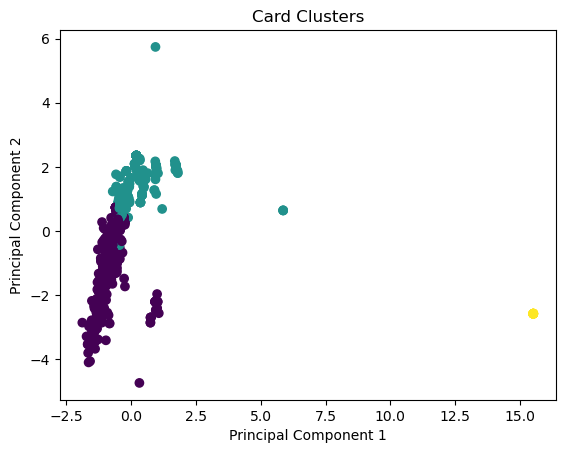

In [1384]:
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=df_to_cluster['cluster'], cmap='viridis')
plt.title('Card Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [1385]:
sil = silhouette_score(data_scaled, df_to_cluster["cluster"])

In [1386]:
sil

0.1825717452181311